In [1]:
import pandas as pd
import numpy as np

RSEED = 42
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')

from tqdm import tqdm

import tensorflow as tf
tf.random.set_seed(RSEED)
from tensorflow.keras.layers import Concatenate

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score  


from survive import SurvivalData
from survive import KaplanMeier



import sys
sys.path.append('/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/AE')
import models, run_models

sys.path.append('/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/helper_functions')
import helpers, clustering_helpers


import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)





2023-12-01 14:42:31.539869: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In  models file
Using TensorFlow backend
In run_models python file


In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 


### Read the datasets 

In [3]:
time_series_2d = np.load('preprocessing/representations/time_series_2d_scaled_angus.npy')
time_series_3d = np.load('preprocessing/representations/time_series_3d_scaled_angus.npy')

static = pd.read_csv('preprocessing/representations/static_eq_angus.csv')
time_series_2d_df = pd.read_csv('preprocessing/representations/time_series_2d_scaled_df_angus.csv')

In [4]:
time_series_2d.shape

(2867, 24, 48)

In [5]:
time_series_3d.shape

(2867, 24, 48)

In [6]:
time_series_2d_df = time_series_2d_df.set_index('icustay_id')

time_series_2d_df.shape

(2867, 48)

In [7]:
print('static shape before dropping empty values', static.shape)

static = static.loc[:, static.gt(0).mean() >= .1]
print('static shape after dropping empty values', static.shape)


static shape before dropping empty values (2867, 52)
static shape after dropping empty values (2867, 31)


In [8]:
static.columns

Index(['icustay_id', 'vent', 'F', 'M', 'adults', 'seniors', 'race_white',
       'gcs_13_15', 'gcs_9_12', 'gcs_<8', 'congestive_heart_failure',
       'cardiac_arrhythmias', 'hypertension', 'other_neurological',
       'chronic_pulmonary', 'diabetes_uncomplicated', 'hypothyroidism',
       'renal_failure', 'liver_disease', 'coagulopathy', 'fluid_electrolyte',
       'alcohol_abuse', 'depression', 'diabetes', 'circulatory',
       'circulatory_infectious_congenital', 'nervous_and_sense',
       'endocrinal_nutritional', 'neoplasms', 'blood_and_blood_forming',
       'mental'],
      dtype='object')

In [9]:
static = static.set_index('icustay_id')

#angus
static = static[['vent', 'F', 'M', 'adults', 'seniors', 'race_white', 'gcs_13_15',
       'gcs_9_12', 'gcs_<8', 'congestive_heart_failure', 'cardiac_arrhythmias',
       'hypertension', 'other_neurological', 'chronic_pulmonary',
       'hypothyroidism', 'renal_failure',
       'liver_disease', 'coagulopathy', 'fluid_electrolyte', 'alcohol_abuse',
       'depression', 'diabetes', 'circulatory',
       'circulatory_infectious_congenital', 'nervous_and_sense',
       'endocrinal_nutritional', 'neoplasms', 'blood_and_blood_forming',
       'mental']]
    
static.shape

(2867, 29)

In [10]:

time_series_3d = time_series_3d.astype(np.float32)
static = static.astype(float)


## Load models

In [11]:
static = static.fillna(0)

In [12]:
## load the encoded representations

path = f'results_EQ_angus/saved_models' 
latent_ts, latent_st, latent_mm = helpers.load_encoded_spaces(time_series_3d, static, 'latent_4(5)_EQ', path)
#helpers.

 1/90 [..............................] - ETA: 11s

90/90 [==============================] - 0s 2ms/step
STATIC AE SHAPE: (2867, 4)
90/90 [==============================] - 1s 5ms/step
GRU SHAPE: (2867, 8)
90/90 [==============================] - 2s 7ms/step
MM SHAPE: (2867, 10)


## Multiple runs model

In [13]:


# path = f'results_EQ_angus/saved_models_avg' 
# num_runs = 10
# all_encoded_static = []
# all_encoded_time_series = []
# all_encoded_mm = []

# for run in tqdm(range(num_runs), desc="Training Autoencoders"):
#     current_seed = RSEED + run  # Use a different seed for each run
#     tf.random.set_seed(current_seed)
#     np.random.seed(current_seed)
#     print(run, current_seed)

#     latent_ts, latent_st, latent_mm = helpers.load_encoded_spaces(time_series_3d, static, f'latent_avg_{run}', path)
#     all_encoded_static.append(latent_st)
#     all_encoded_time_series.append(latent_ts)
#     all_encoded_mm.append(latent_mm)
    
# # Compute the average of the encoded representations
# average_encoded_static = np.mean(all_encoded_static, axis=0)
# average_encoded_time_series = np.mean(all_encoded_time_series, axis=0)
# average_encoded_mm = np.mean(all_encoded_mm, axis=0)



## Baselines


In [ ]:
bool_list = [True] * len(static.columns) + [False] * len(time_series_2d_df.columns) 

#time series should be false
best_method_baseline, best_silhouette_score_baseline, best_model_baseline, results_df_baseline, best_labels_baseline = \
    clustering_helpers.compare_clustering_methods_baselines(static, time_series_2d_df, bool_list, 'BASELINE', max_clusters=5)

In [ ]:
np.bincount(best_labels_baseline)

In [ ]:
results_df_baseline

results_df_baseline.to_csv(f'{path}/metrics/baselines_results.csv')

## Comparison of fusions 

In [14]:
# latent_late_fusion = Concatenate()([latent_ts, latent_st])
# latent_late_fusion = np.array(latent_late_fusion)
# #average_late_fusion = Concatenate()([average_encoded_static, average_encoded_static])
# #average_late_fusion = np.array(average_late_fusion)
# data = [latent_st, latent_ts, latent_mm, latent_late_fusion]
# #average_encoded_static, average_encoded_time_series, average_encoded_mm, average_late_fusion
# #latent_st, latent_ts, latent_mm, latent_late_fusion
# dataset_name = ['st', 'ts', 'mm', 'lf']
# #'st', 'ts', 'mm', 'lf'
# #'encoded_static', 'encoded_time_series', 
# # data = [encoded_mm, encoded_late_fusion]

# results = pd.DataFrame()
# best_labels = pd.DataFrame()
# all_labels = pd.DataFrame()
# for i, y in zip(data, dataset_name):
#     df_results, best_labels_, labels_df, best_model = clustering_helpers.compare_kmeans_hdbscan(i, dataset_name = y,  max_k=100)

#     df_results.index = [y, y, y]

#     y = f'{y}_{best_model}'
#     labels_ = pd.Series(best_labels_, name=y)
#     best_labels = pd.concat([best_labels, labels_], axis=1)
#     all_labels = pd.concat([all_labels, labels_df], axis=1)
    

#     #results = results.append(df_results)
#     results = pd.concat([results, df_results])

In [16]:
# import os
path = f'results_EQ' 


# if not os.path.isdir(f"{path}/metrics"):

#     os.makedirs(f"{path}/metrics")

# results.to_csv(f'{path}/metrics/ae_results.csv')
# all_labels.to_csv(f'{path}/metrics/all_labels.csv')

results  = pd.read_csv(f'{path}/metrics/ae_results.csv')
all_labels = pd.read_csv(f'{path}/metrics/all_labels.csv')

In [17]:
all_labels['mm_Agglomerative'].value_counts().sort_index()

0     160
1      98
2      70
3      91
4     109
5      77
6      84
7      47
8     112
9     191
10     47
11     77
12    171
13     40
14     60
15    199
16    193
17    154
18     47
19    103
20    140
21    142
22    133
23     76
24    209
25     37
Name: mm_Agglomerative, dtype: int64

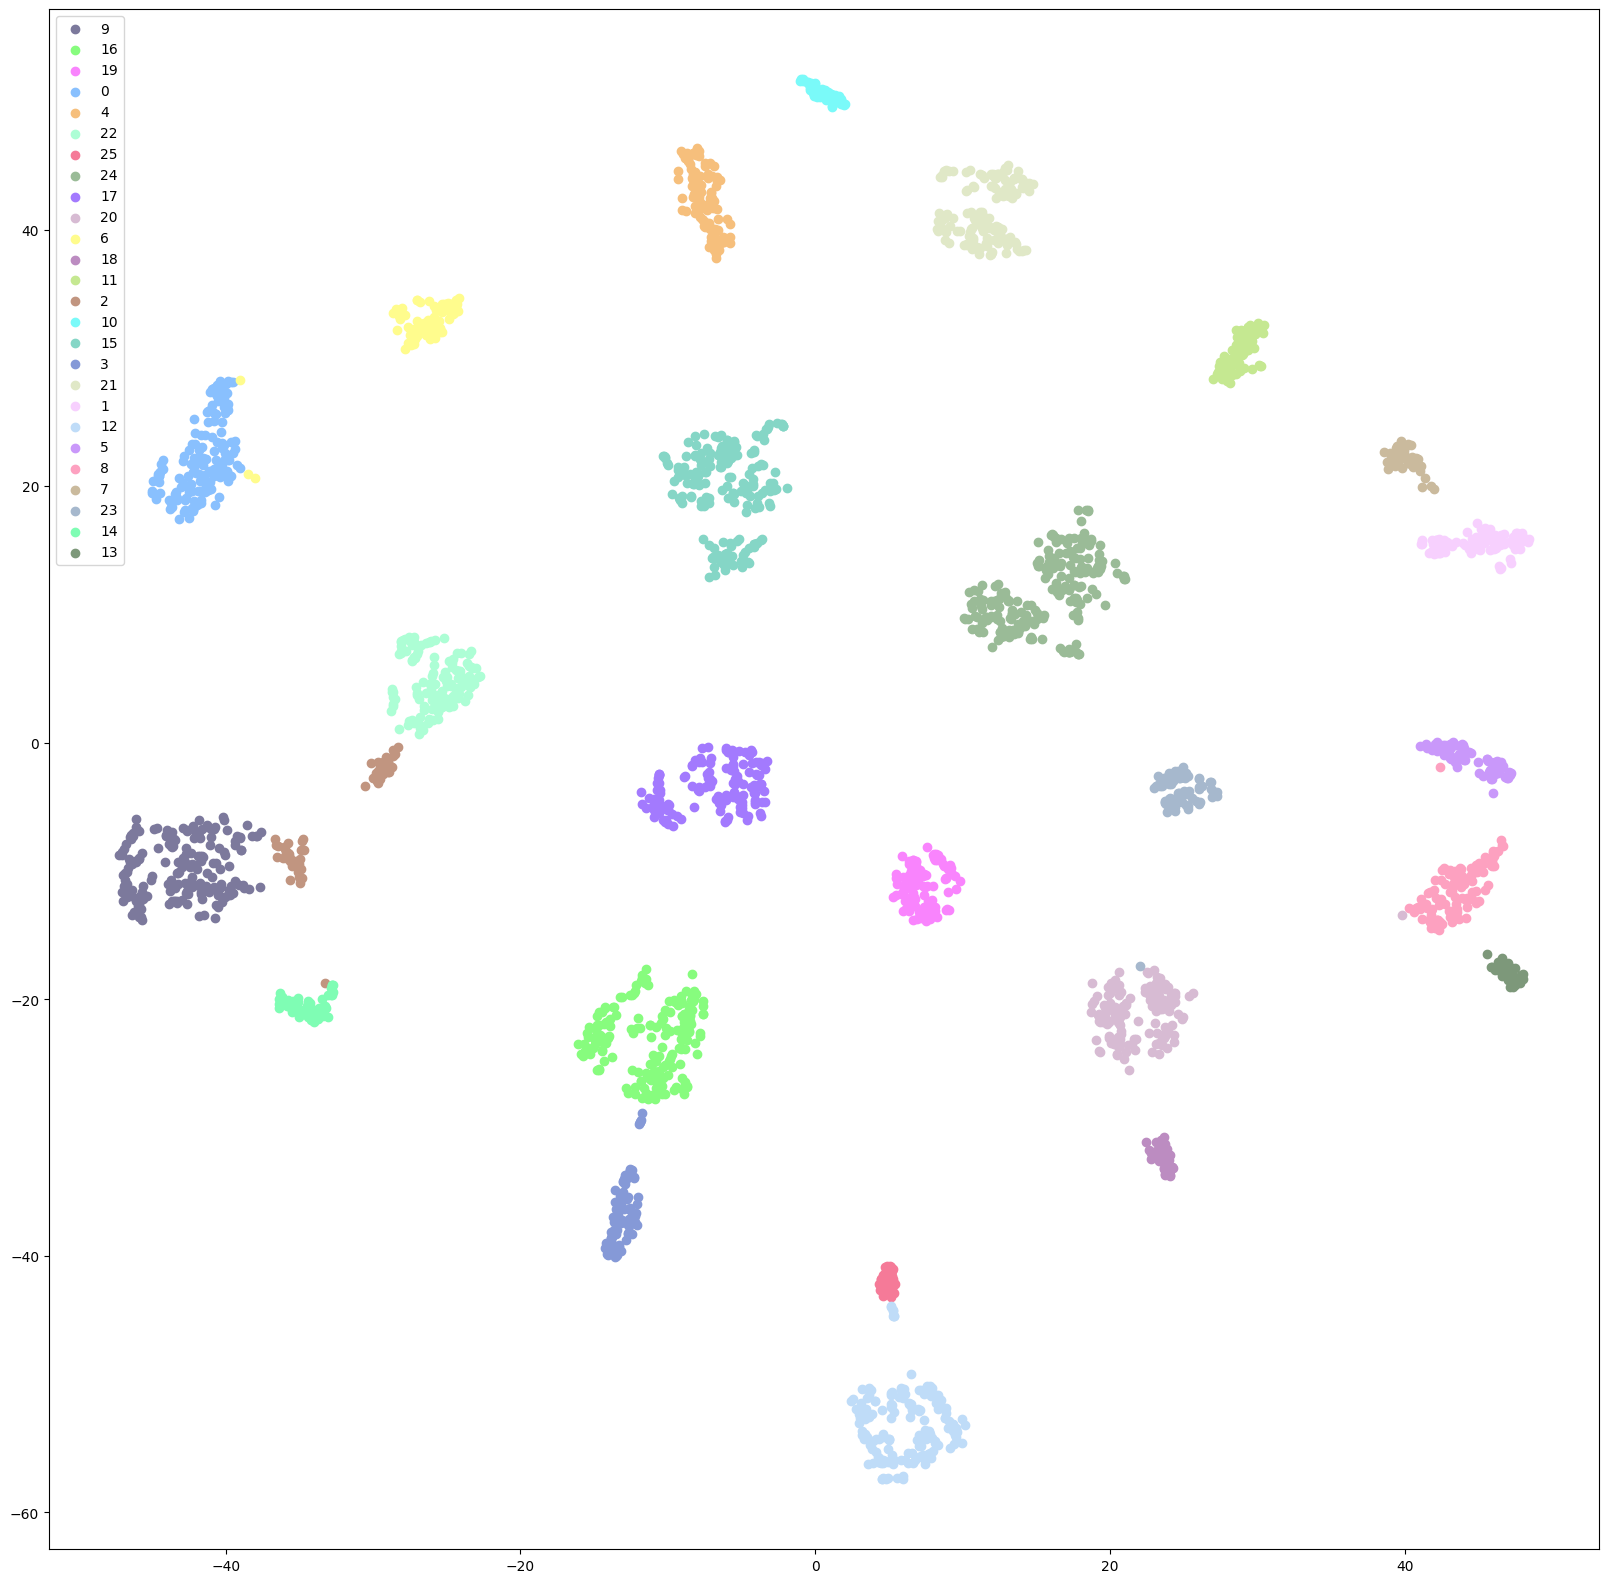

In [18]:
from sklearn.manifold import TSNE
import distinctipy

best_reduced_data = TSNE(n_components=2, random_state=2, perplexity=50).fit_transform(latent_mm) 
plt.figure(figsize=(20, 20))

# Get unique categories and corresponding colors
unique_categories = all_labels['mm_Agglomerative'].unique()
num_categories = len(unique_categories)

# number of colours to generate
N = 26

# generate N visually distinct colours
colors = distinctipy.get_colors(N, pastel_factor=0.9)

# Create a scatter plot for each category
for i, category in enumerate(unique_categories):
    category_mask = all_labels['mm_Agglomerative'] == category
    plt.scatter(best_reduced_data[:,0][category_mask], best_reduced_data[:,1][category_mask], c=[colors[i]], label=category)

# Display the legend
plt.legend()

plt.show()

In [19]:
results

,Unnamed: 0,Model,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
0,st,KMeans,0.267791,1.133165,673.675794
1,st,HDBSCAN,0.384450,1.918312,410.141809
2,st,Agglomerative,0.287640,1.065371,432.130822
3,ts,KMeans,0.247677,1.371686,622.290334
4,ts,HDBSCAN,0.154194,2.102885,452.291419
5,ts,Agglomerative,0.366131,1.129621,321.241728
6,mm,KMeans,0.525151,0.665582,3423.205602
7,mm,HDBSCAN,0.449031,1.711448,2148.364167
8,mm,Agglomerative,0.566410,0.650025,4721.698721
9,lf,KMeans,0.152216,1.703240,381.699024


In [20]:
# plt.style.use('default')
# # Perform cluster stability analysis using Spectral
# labels_ = ['mm_Agglomerative']
# jaccard_indices_mm = clustering_helpers.cluster_stability(latent_mm, all_labels[labels_][labels_[0]].values, 26, 'agglomerative', num_iterations=100)
# mean_jaccard_mm = np.mean(jaccard_indices_mm)

# labels_ = ['lf_HDBSCAN']
# # Perform cluster stability analysis using KMeans
# jaccard_indices_lf = clustering_helpers.cluster_stability(latent_late_fusion, all_labels[labels_][labels_[0]].values, 3, 'hdbscan', num_iterations=100)
# mean_jaccard_lf = np.mean(jaccard_indices_lf)

# # Plotting ARI and Jaccard Index across the runs
# plt.figure(figsize=(6, 6))
# plt.plot(range(1, len(jaccard_indices_mm) + 1), jaccard_indices_mm, label="Jaccard Index MMAE: {0:.2}".format(mean_jaccard_mm), marker='o')
# plt.plot(range(1, len(jaccard_indices_lf) + 1), jaccard_indices_lf, label="Jaccard Index EFAE: {0:.2}".format(mean_jaccard_lf) , marker='o')
# plt.xlabel("Bootstrap Iteration")
# plt.ylabel("Index Value")
# plt.legend()
# plt.tight_layout()

# plt.show()



## KM

In [21]:
folder_sepsis = 'sepsis3_queries/data'
sepsis3 = pd.read_csv(f'{folder_sepsis}/sepsis-df-3.csv')
sepsis3 = sepsis3[sepsis3.sepsis_angus == 1]
sepsis3 = sepsis3.set_index('icustay_id')

In [22]:
all_labels.columns

Index(['icustay_id', 'st_KMeans', 'st_HDBSCAN', 'st_Agglomerative',
       'ts_KMeans', 'ts_HDBSCAN', 'ts_Agglomerative', 'mm_KMeans',
       'mm_HDBSCAN', 'mm_Agglomerative', 'lf_KMeans', 'lf_HDBSCAN',
       'lf_Agglomerative'],
      dtype='object')

In [23]:
all_labels.index = sepsis3.index

In [24]:
# labels_ = ['mm_Agglomerative']


# sns.set(style="darkgrid", palette="colorblind", color_codes=True)



# for modality in labels_:
#     kmd = sepsis3.join(all_labels[modality])
#     surv = SurvivalData(time="icu_los", status="mort_icu", group=modality, data=kmd)
#     print(kmd.groupby(modality)['mort_icu'].value_counts())

#     #observed lifetimes of all the individuals in the data. Censored individuals are marked at the end of their lifespan.
#     plt.figure(figsize=(20, 16))
#     surv.plot_lifetimes()
#     plt.title(modality)
#     plt.show()
#     plt.close()

#     #kaplan meier
#     km = KaplanMeier()
#     km.fit(surv)

#     #display(km.summary())
#     # abulates the survival probability estimates and thier 
#     # standard error and confidence intervals for the event times within each group. 
#     # It can be printed to display all the information at once.
#     #print(km.summary)
#     plt.figure(figsize=(20, 16))
#     km.plot()
#     plt.title(modality)
#     plt.show()
#     plt.close()


#     estimate = km.predict([1, 3, 5, 10, 30])
#     # estimated probabiltiies for surviving past a certain time for each group.
#     print(modality)
#     display(estimate)

## Heatmaps

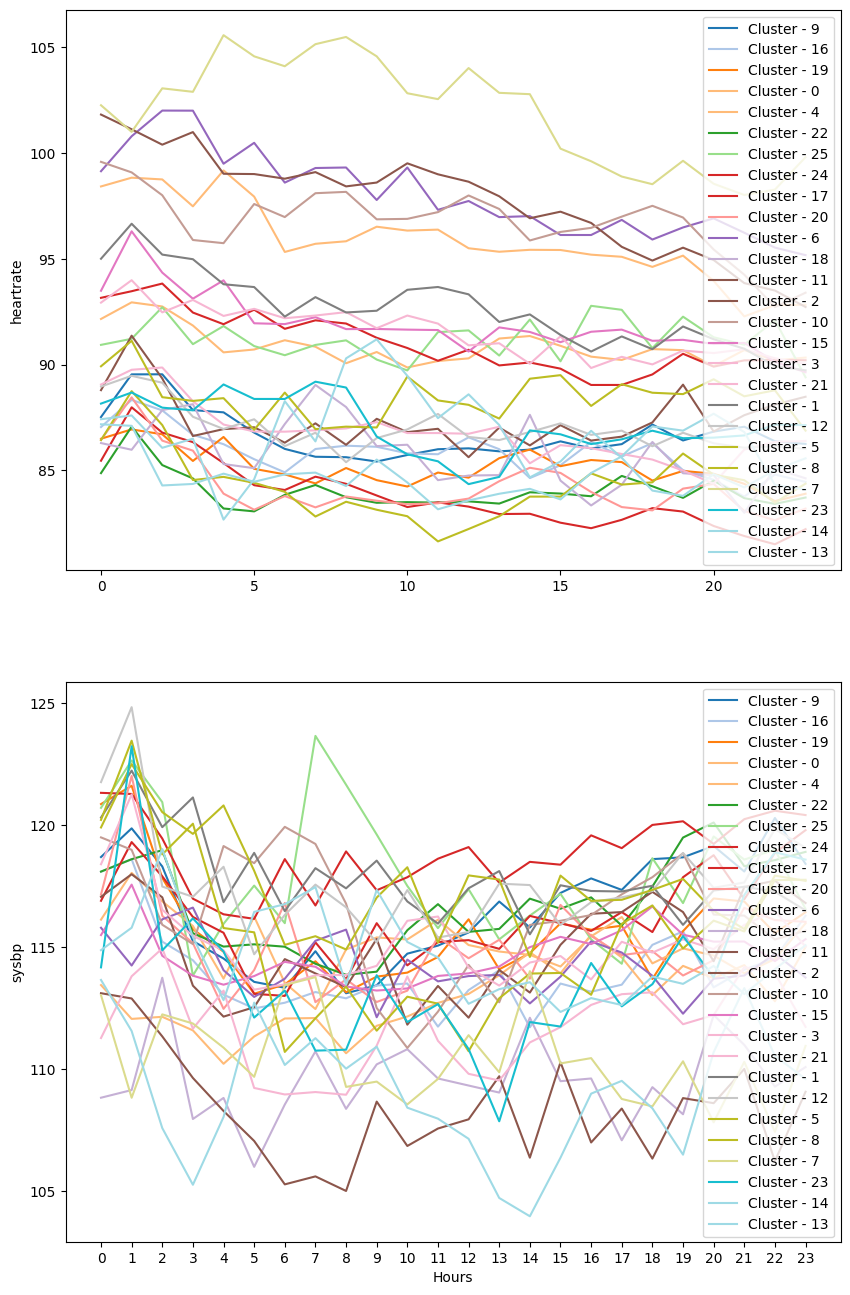

In [25]:

labels_ = ['mm_Agglomerative']


time_series_3d_df = pd.read_csv('preprocessing/representations/time_series_3d_angus.csv')
time_series_3d_df = time_series_3d_df.set_index('icustay_id')
temp = time_series_3d_df.join(all_labels[labels_])
features_to_plot = ['heartrate', 'sysbp']


clustering_helpers.plot_hourly_means_by_label(temp, features_to_plot, label_column=labels_[0])


In [26]:
warnings.filterwarnings("ignore") 
feature_columns_to_check = ['bun']
mortality_columns_to_check = ['hospital_expire_flag', 'thirtyday_expire_flag', 'mort_icu', 'mort_hosp']
result = clustering_helpers.calculate_cluster_correlation_multiple_features(temp, labels_[0], feature_columns_to_check, sepsis3, mortality_columns_to_check)


## Cluster size,  outcome characteristics.

In [27]:
from tableone import TableOne
warnings.filterwarnings("ignore") 

sepsis3temp1 = sepsis3[['hospital_expire_flag', 'thirtyday_expire_flag', 'mort_icu',
       'icu_los', 'hosp_los']]

sepsis3temp1 = (static[['adults', 'seniors']]).join(sepsis3temp1).join(all_labels[labels_])


sepsis3temp1 = sepsis3temp1.rename(columns={'thirtyday_expire_flag':'30 day mortality', 'hospital_expire_flag':'in hospital mortality','mort_icu':'in icu mortality',\
                                            'icu_los':'icu length of stay','hosp_los':'hospital length of stay' })

table1_sepsis3 = TableOne(sepsis3temp1, groupby=labels_, missing=False, tukey_test=True, normal_test=True, pval=True, pval_adjust=True, display_all=True)

print(table1_sepsis3)

                                       Grouped by mm_Agglomerative                                                                                                                                                                                                                                                                                                                                                                 
                                                           Overall            0            1           10           11           12           13          14           15           16           17           18           19           2           20           21           22           23           24           25            3            4           5           6            7            8            9 P-Value (adjusted)
n                                                             2867          160           98           47           77          171           40          60    

In [28]:
from tableone import TableOne
warnings.filterwarnings("ignore") 

sepsis3temp1 = sepsis3[['hospital_expire_flag', 'thirtyday_expire_flag', 'mort_icu',
       'icu_los', 'hosp_los']]

sepsis3temp1 = (static[['adults', 'seniors']]).join(sepsis3temp1).join(all_labels[labels_])


sepsis3temp1 = sepsis3temp1.rename(columns={'thirtyday_expire_flag':'30 day mortality', 'hospital_expire_flag':'in hospital mortality','mort_icu':'in icu mortality',\
                                            'icu_los':'icu length of stay','hosp_los':'hospital length of stay' })

table1_sepsis3 = TableOne(sepsis3temp1, groupby=labels_, missing=False, tukey_test=True, normal_test=True, pval=True, pval_adjust=True, display_all=True)

print(table1_sepsis3)


                                       Grouped by mm_Agglomerative                                                                                                                                                                                                                                                                                                                                                                 
                                                           Overall            0            1           10           11           12           13          14           15           16           17           18           19           2           20           21           22           23           24           25            3            4           5           6            7            8            9 P-Value (adjusted)
n                                                             2867          160           98           47           77          171           40          60    

In [29]:
#print(table1_sepsis3.tabulate(tablefmt = "latex"))


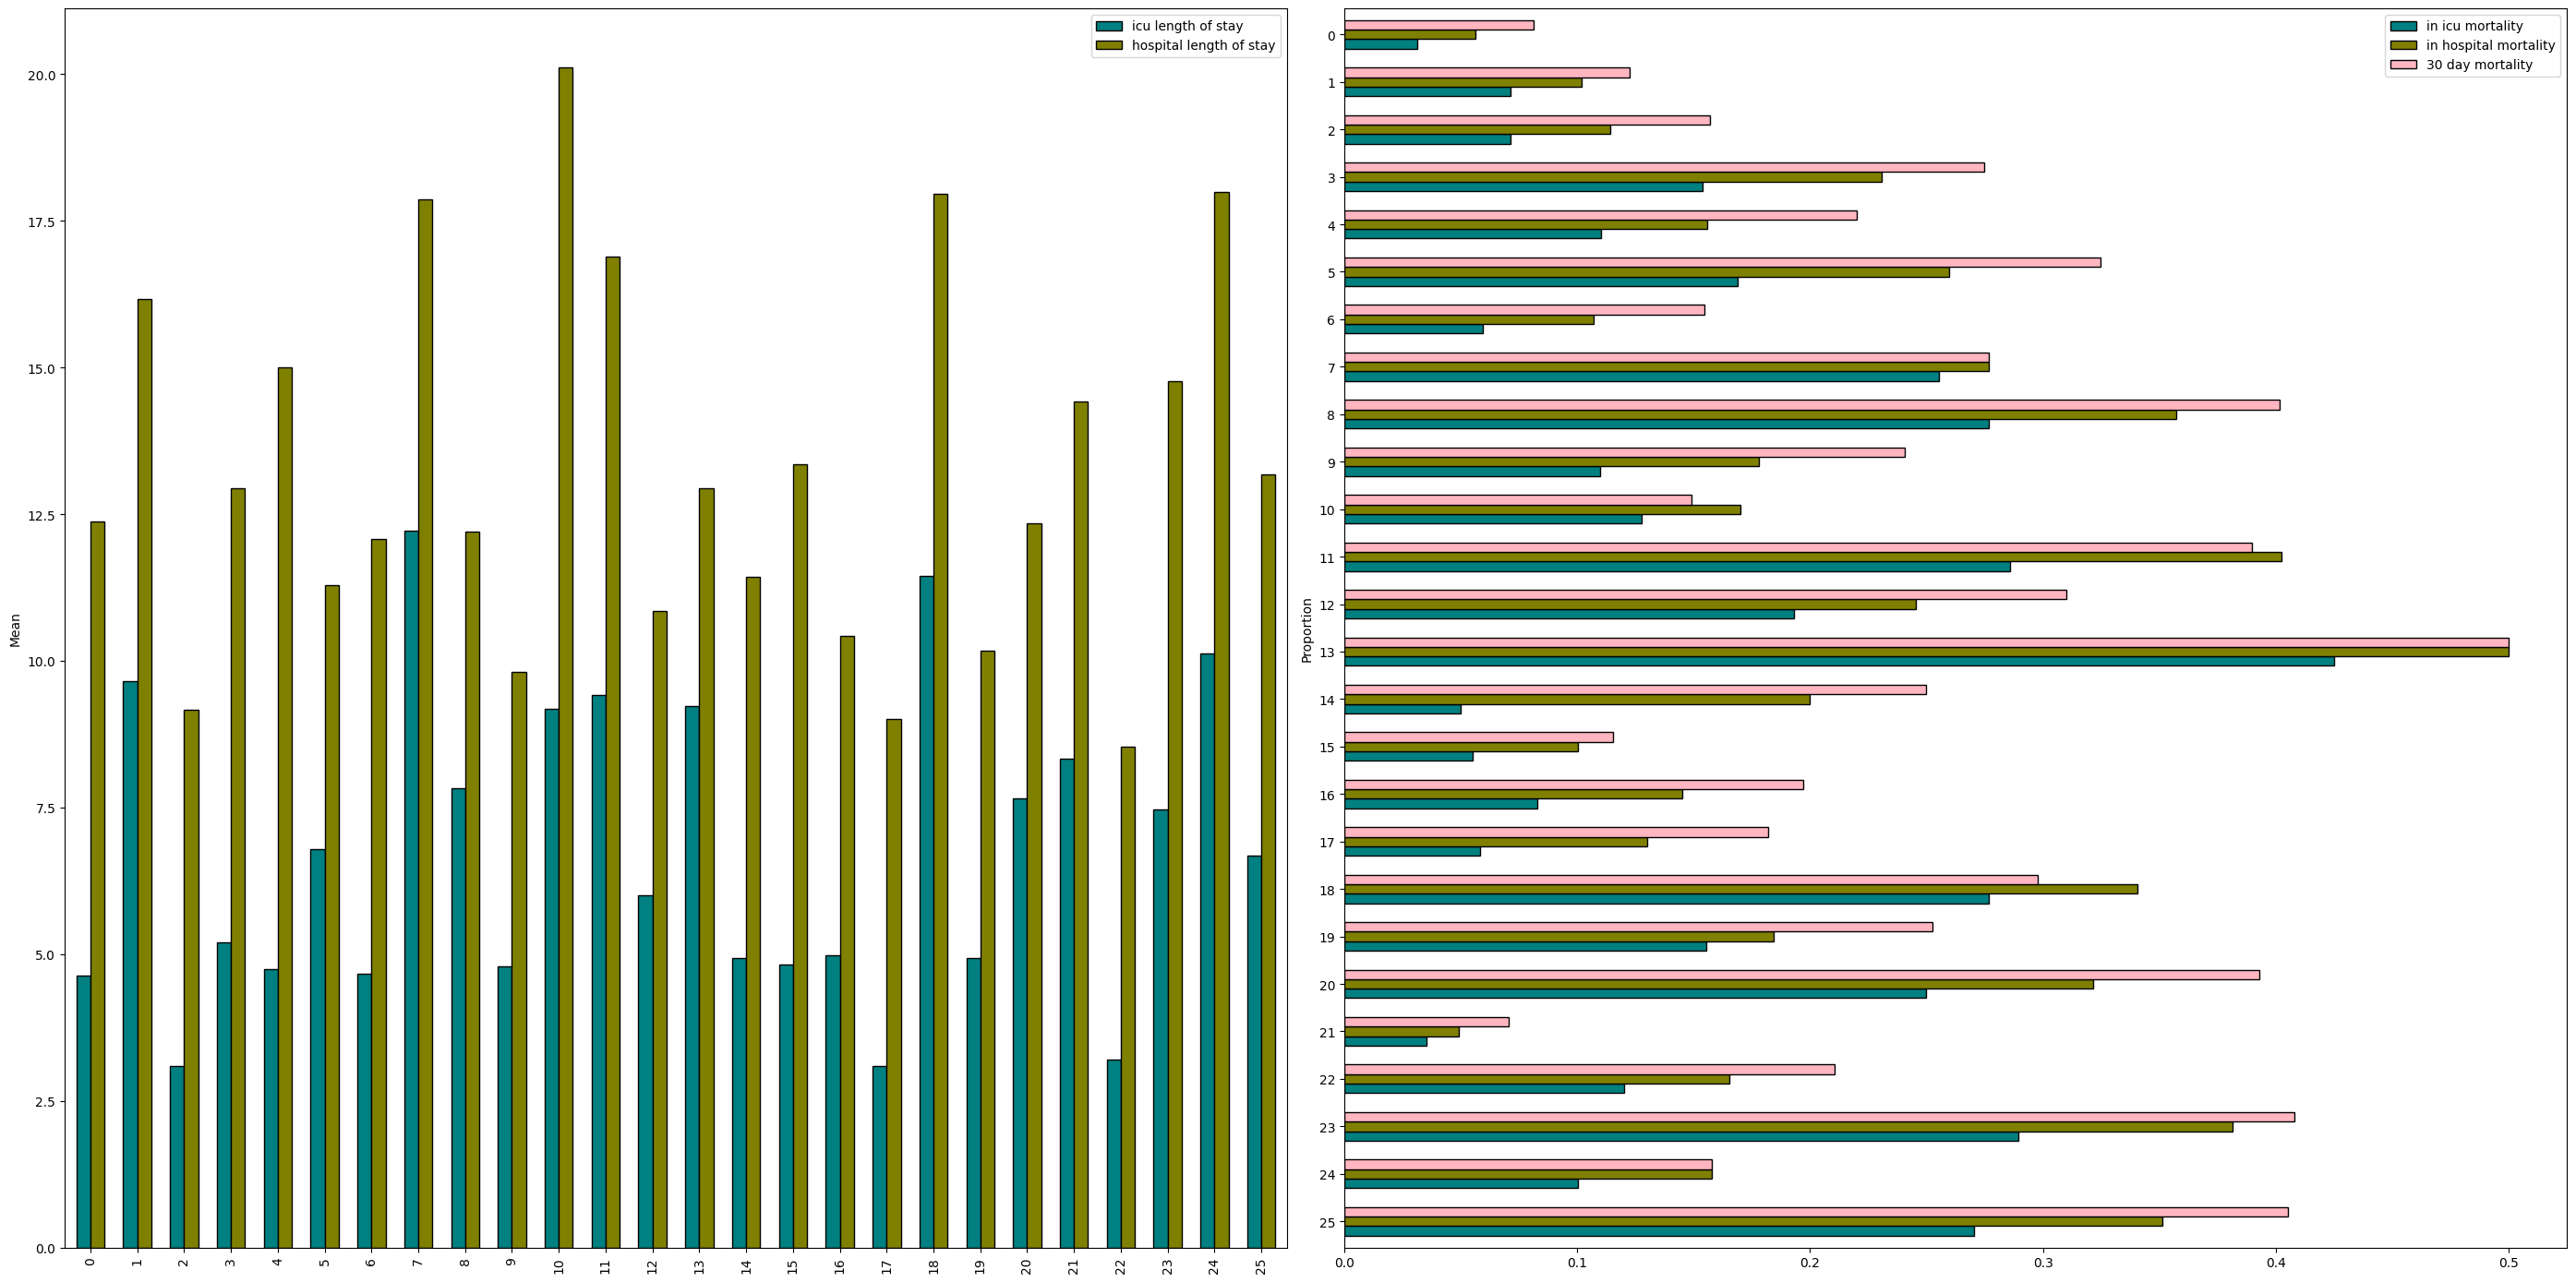

In [30]:
custom_colors = ['teal', 'olive', 'lightpink']

clustering_helpers.grouped_bar_plots(sepsis3temp1, [['icu length of stay', 'hospital length of stay'], ['in icu mortality', 'in hospital mortality','30 day mortality' ]], 
                  labels_[0], custom_colors, bar_width=0.6)


In [31]:
table = TableOne(sepsis3temp1, groupby= labels_, pval = True,pval_adjust='bonferroni', smd=False,
                  htest_name=True, display_all=True)
table

Grouped by mm_Agglomerative                                                                                                                                                                                                                                                                                                                                                                                                                         
                                                           Missing      Overall            0            1           10           11           12           13          14           15           16           17           18           19           2           20           21           22           23           24           25            3            4           5           6            7            8            9 P-Value (adjusted)                                       Test
n                                                                          2867          160           98           47           77          171           40          60          199          193          154           47          103          70          140          142          133           76          209           37           91          109          77          84           47          112          191                                                              
adults, n (%)                      0.0                           0  1748 (61.0)      6 (3.8)      6 (6.1)      3 (6.4)      2 (2.6)  171 (100.0)   40 (100.0)  60 (100.0)      3 (1.5)  193 (100.0)  154 (100.0)   47 (100.0)  103 (100.0)  70 (100.0)  140 (100.0)      8 (5.6)  133 (100.0)   76 (100.0)     14 (6.7)   37 (100.0)   91 (100.0)      4 (3.7)  77 (100.0)     6 (7.1)      1 (2.1)  112 (100.0)  191 (100.0)             <0.001                                Chi-squared
                                   1.0                              1119 (39.0)   154 (96.2)    92 (93.9)    44 (93.6)    75 (97.4)                                         196 (98.5)                                                                                134 (94.4)                             195 (93.3)                             105 (96.3)               78 (92.9)    46 (97.9)                                                                                        
seniors, n (%)                     0.0                           0  1172 (40.9)  160 (100.0)   98 (100.0)   47 (100.0)   77 (100.0)                                        199 (100.0)                                                                               142 (100.0)                            209 (100.0)                            109 (100.0)              84 (100.0)   47 (100.0)                                       <0.001                                Chi-squared
                                   1.0                              1695 (59.1)                                                      171 (100.0)   40 (100.0)  60 (100.0)               193 (100.0)  154 (100.0)   47 (100.0)  103 (100.0)  70 (100.0)  140 (100.0)               133 (100.0)   76 (100.0)                37 (100.0)   91 (100.0)               77 (100.0)                           112 (100.0)  191 (100.0)                                                              
in hospital mortality, n (%)       0                             0  2321 (81.0)   151 (94.4)    88 (89.8)    39 (83.0)    46 (59.7)   129 (75.4)    20 (50.0)   48 (80.0)   179 (89.9)   165 (85.5)   134 (87.0)    31 (66.0)    84 (81.6)   62 (88.6)    95 (67.9)   135 (95.1)   111 (83.5)    47 (61.8)   176 (84.2)    24 (64.9)    70 (76.9)    92 (84.4)   57 (74.0)   75 (89.3)    34 (72.3)    72 (64.3)   157 (82.2)             <0.001                                Chi-squared
                                   1                                 546 (19.0)      9 (5.6)    10 (10.2)     8 (17.0)    31 (40.3)    42 (24.6)    20 (50.0)   12 (20.0)    20 (10.1)    28 (14.5)    20 (13.0)    16 (34.0)    19 (18

In [30]:
# table1_1 = table1_sepsis3.tableone.T.droplevel(0).reset_index().replace('Overall', -1)
# table1_1 = table1_1.replace('P-Value (adjusted)', 182)
# table1_1['index'] = table1_1['index'].astype(int)

# table1_1 = table1_1.sort_values(by='index')

# table1_1 = table1_1.replace( 182, 'P-Value (adjusted)')
# table1_1 = table1_1.replace(-1, 'Overall')
# table1_1 = table1_1.set_index('index')
# table1_1

### Diagnoses at admission and end of hospital stay

In [32]:
# diagnoses_at_admission = sepsis3[[
#     'diagnosis'
# ]]

# diagnoses_at_admission = diagnoses_at_admission.join(all_labels[labels_])

# diagnoses_at_admission.groupby('mm_Agglomerative').value_counts().reset_index(name='count').groupby('mm_Agglomerative').head(6).set_index('mm_Agglomerative')


In [33]:
# diagnoses = pd.read_csv(f'{folder_sepsis}/diagnoses.csv')
# diagnoses = diagnoses[diagnoses.hadm_id.isin(sepsis3.hadm_id)]
# sepsis3 = sepsis3.join(all_labels[labels_])
# sepsis3 = sepsis3.reset_index().set_index('hadm_id')
# diagnoses = diagnoses.set_index('hadm_id')
# diagnoses = diagnoses.join(sepsis3)
# sepsis3 = sepsis3.reset_index().set_index('icustay_id')

# diagnoses = diagnoses.reset_index().set_index('icustay_id')
# diagnoses = diagnoses[['icd9_code', 'icd9_title', 'mm_Agglomerative']]
# # Mapping dictionary with ranges
# icd9_mapping = {
#     'Infectious and Parasitic Diseases': ('001', '139'),
#     'Neoplasms': ('140', '239'),
#     'Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders': ('240', '279'),
#     'Diseases of the Blood and Blood-Forming Organs': ('280', '289'),
#     'Mental Disorders': ('290', '319'),
#     'Diseases of the Nervous System and Sense Organs': ('320', '389'),
#     'Diseases of the Circulatory System': ('390', '459'),
#     'Diseases of the Respiratory System': ('460', '519'),
#     'Diseases of the Digestive System': ('520', '579'),
#     'Diseases of the Genitourinary System': ('580', '629'),
#     'Complications of Pregnancy, Childbirth, and the Puerperium': ('630', '679'),
#     'Diseases of the Skin and Subcutaneous Tissue': ('680', '709'),
#     'Diseases of the Musculoskeletal System and Connective Tissue': ('710', '739'),
#     'Congenital Anomalies': ('740', '759'),
#     'Certain Conditions Originating in the Perinatal Period': ('760', '779'),
#     'Symptoms, Signs, and Ill-Defined Conditions': ('780', '799'),
#     'Injury and Poisoning': ('800', '999'),
#     'External Causes of Injury and Supplemental Classification': ('E00', 'V99')
# }
# diagnoses['upper_hierarchy'] = diagnoses['icd9_code'].str[:3]
# # Check if icd9_code falls within the specified range for each category
# for category, (lower, upper) in icd9_mapping.items():
#     diagnoses[category] = diagnoses['upper_hierarchy'].between(lower, upper)

# diagnoses['Combinedicd9'] = diagnoses.apply(lambda row: ' '.join(row.iloc[4:].index[row.iloc[4:]]), axis=1)
# diagnoses = diagnoses[['icd9_code',	'icd9_title',	'mm_Agglomerative',	'upper_hierarchy', 'Combinedicd9']]
# freq_diagnoses = diagnoses.groupby('icustay_id').Combinedicd9.value_counts().reset_index(name='count').groupby('icustay_id').head(1).set_index('icustay_id')
# freq_diagnoses = freq_diagnoses.join(diagnoses['mm_Agglomerative'])
# freq_diagnoses =freq_diagnoses.drop_duplicates()
# freq_diagnoses.drop('count', axis=1).groupby('mm_Agglomerative').value_counts().reset_index(name='count').groupby('mm_Agglomerative').head(2).set_index('mm_Agglomerative')


In [33]:
# custom_colors = ['green', 'orange']


# grouped_bar_plots(sepsis3, [['sofa'], ['sirs'], ['qsofa']], labels_[0], custom_colors)


/Users/maba4574/Desktop/Work/Projects/MIMIC/patient_clustering_EHR/.venv/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


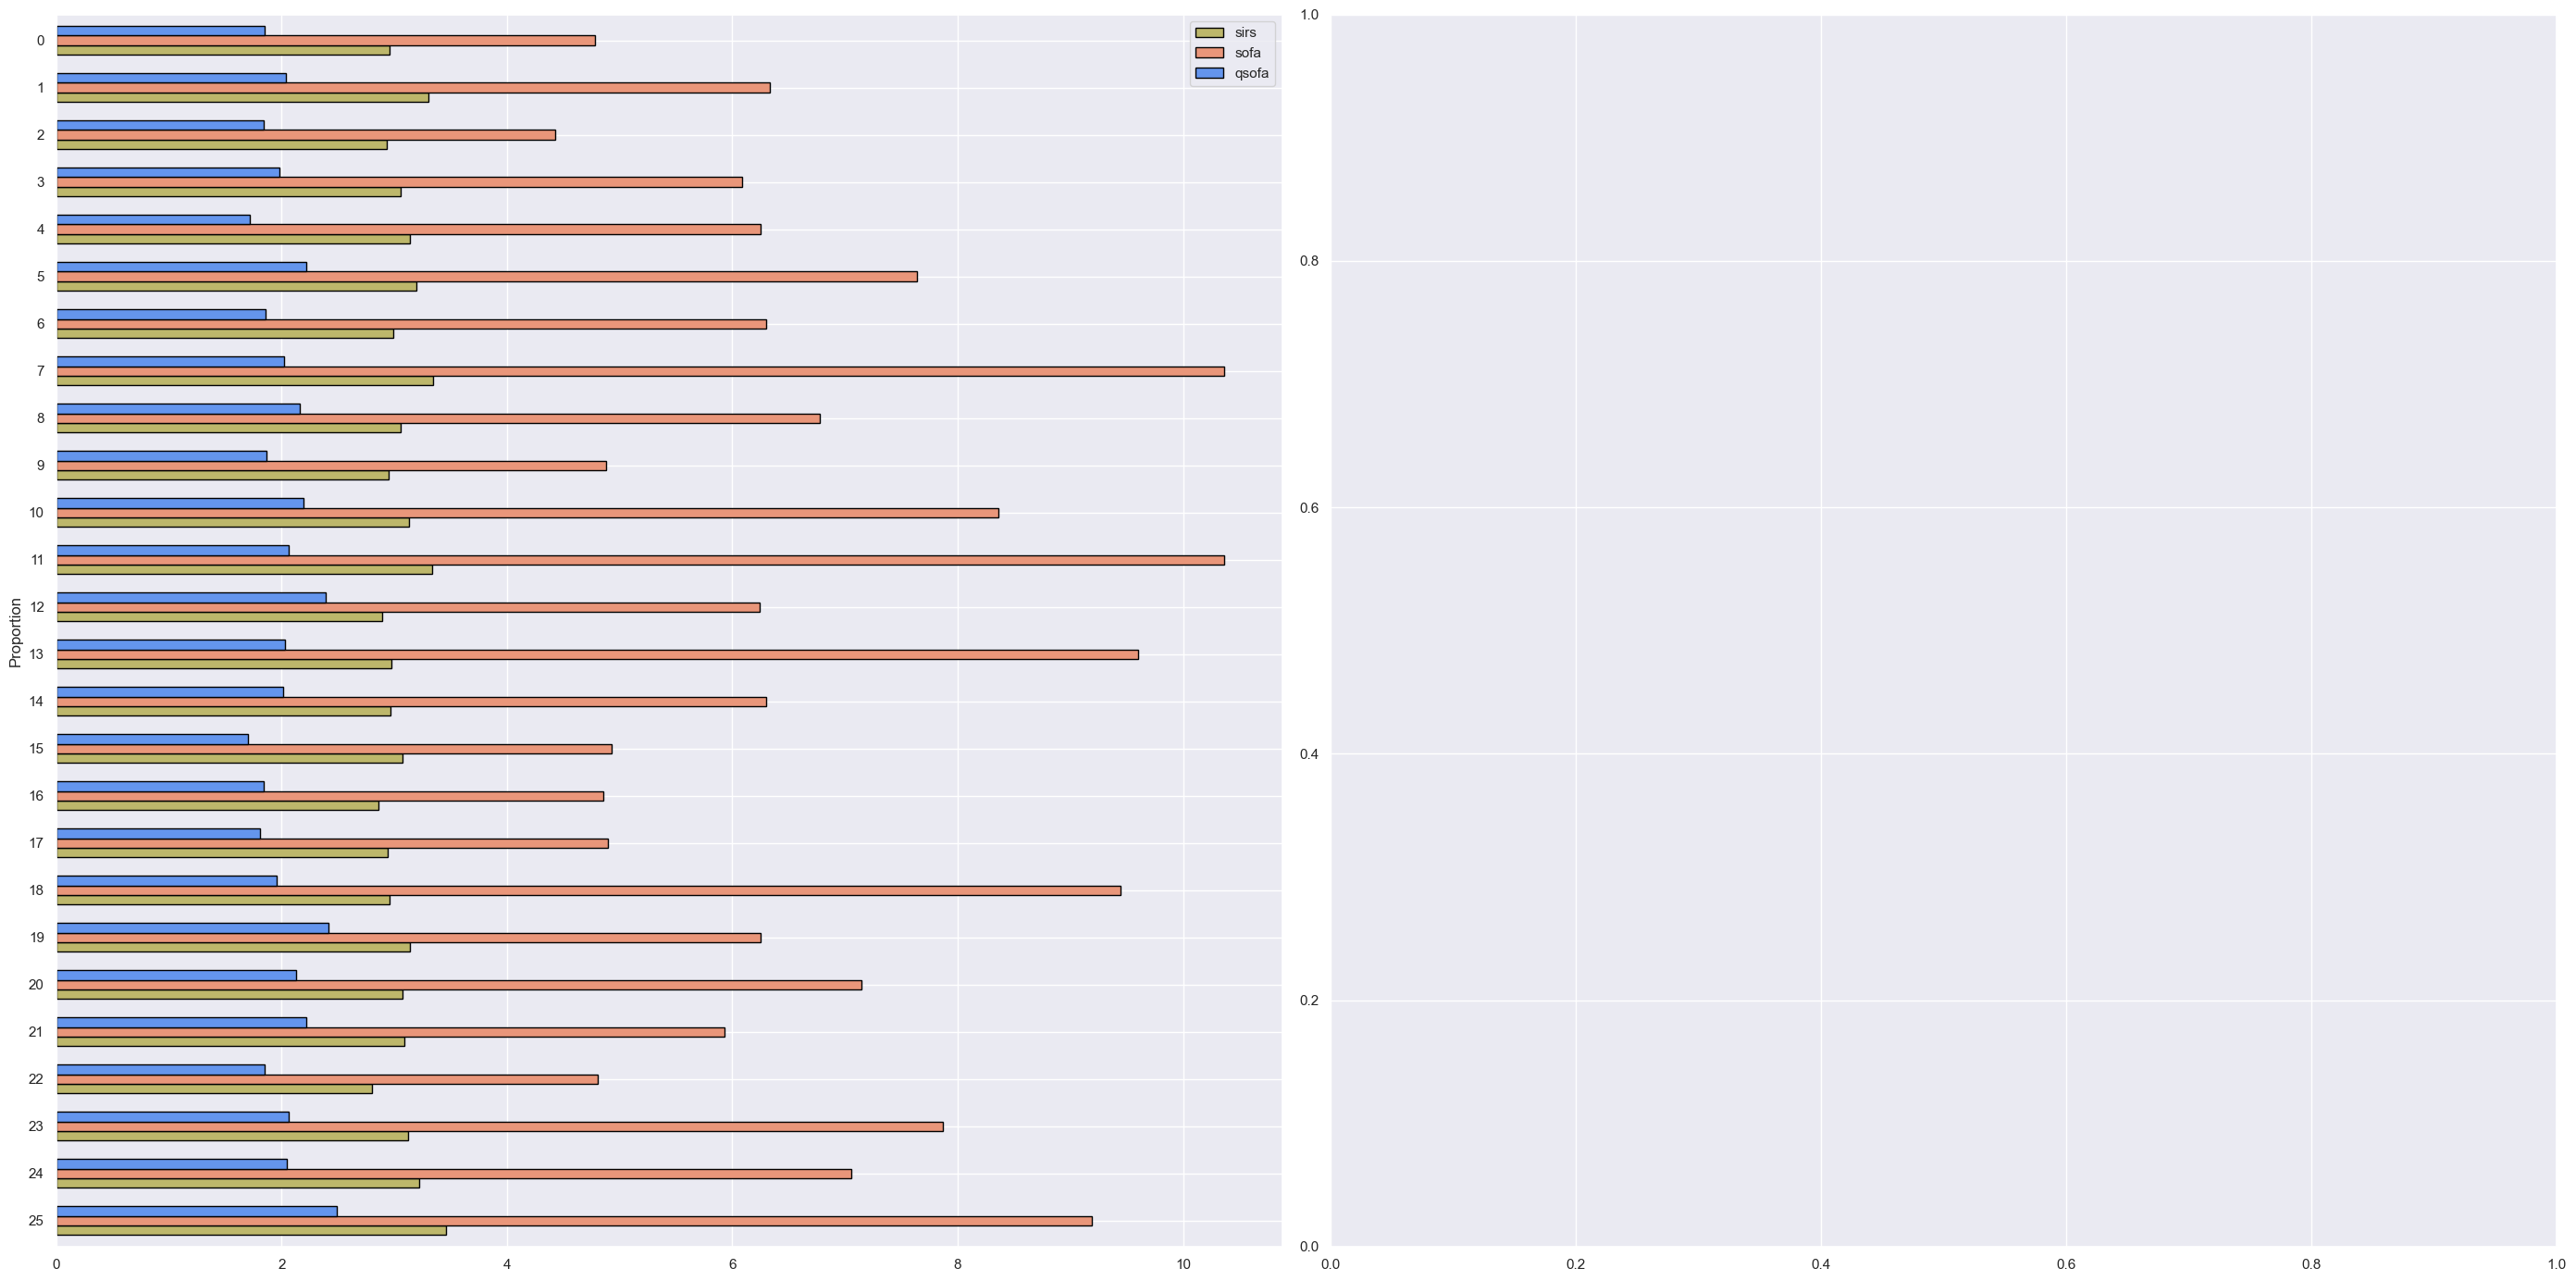

In [34]:
custom_colors = ['darkkhaki', 'darksalmon', 'cornflowerblue']

grouped_bar_plots(sepsis3, [ ['sirs', 'sofa', 'qsofa']], 
                  labels_[0], custom_colors, bar_width=0.6)

In [36]:
sepsis3.groupby(labels_)['sirs', 'sofa', 'qsofa'].mean().append(pd.Series(sepsis3[['sirs', 'sofa', 'qsofa']].mean(), name='overall'))

/var/folders/z8/9rzhj2td0kvbgshc9wpwwtv00000gp/T/ipykernel_31925/1517215790.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sepsis3.groupby(labels_)['sirs', 'sofa', 'qsofa'].mean().append(pd.Series(sepsis3[['sirs', 'sofa', 'qsofa']].mean(), name='overall'))
/var/folders/z8/9rzhj2td0kvbgshc9wpwwtv00000gp/T/ipykernel_31925/1517215790.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sepsis3.groupby(labels_)['sirs', 'sofa', 'qsofa'].mean().append(pd.Series(sepsis3[['sirs', 'sofa', 'qsofa']].mean(), name='overall'))


,sirs,sofa,qsofa
mm_Agglomerative,,,
0,2.956250,4.781250,1.850000
1,3.306122,6.336735,2.040816
2,2.928571,4.428571,1.842857
3,3.054945,6.087912,1.978022
4,3.137615,6.247706,1.715596
5,3.194805,7.636364,2.220779
6,2.988095,6.297619,1.857143
7,3.340426,10.361702,2.021277
8,3.053571,6.776786,2.160714


## Vitals - Labs - Interventions

*Respiratory Parameters:*

aado2
o2flow
fio2
so2
pco2
po2
requiredo2
spo2



*Cardiovascular Parameters:*

heartrate
sysbp
diasbp
meanbp



*Temperature Parameters:*

temperature
tempc




*Blood Gas and Electrolytes:*

baseexcess
bicarbonate
totalco2
carboxyhemoglobin
chloride
calcium
glucose
hematocrit
hemoglobin
lactate
ph
potassium
sodium
aniongap



*Blood Components:*

albumin
bands
bilirubin
creatinine
platelet
ptt
inr
pt
bun
wbc



*Ventilator Parameters:*


peep
tidalvolume
resprate



*Medication Doses:*


dobutamine_dose
dopamine_dose
vasopressin_dose
phenylephrine_dose
epinephrine_dose
norepinephrine_dose



*Urinary Output:*

urineoutput

In [34]:


ts_2d_df = pd.read_csv('preprocessing/representations/time_series_2d_angus.csv')
ts_2d_df = ts_2d_df.set_index('icustay_id')


hd_labels = all_labels[labels_]
hd_labels.index = ts_2d_df.index

temp = ts_2d_df.join(hd_labels)


#### Respiratory

aado2
o2flow
fio2
so2
pco2
po2
requiredo2
spo2

In [35]:
temp_resp = temp[['aado2', 'o2flow', 'fio2',  'so2',  'pco2',  'po2', 'requiredo2', 'spo2', 'mm_Agglomerative']]
nonnormal = list(['aado2', 'o2flow', 'fio2',  'so2',  'pco2',  'po2', 'requiredo2', 'spo2'])

#to check for normality 
#table1 = TableOne(temp_resp, dip_test=True, normal_test=True, tukey_test=True)


table_resp = TableOne(temp_resp, groupby= labels_,  nonnormal=nonnormal, pval = True, pval_adjust='bonferroni', smd=False,
                  htest_name=True)
table_resp

Grouped by mm_Agglomerative                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
                                                Missing              Overall                    0                    1                   10                   11                   12                   13                   14                   15                   16                   17                   18                   19                    2                   20                   21                   22                   23                   24                   25                    3                    4                    5                    6                    7                    8                    9 P-Value (adjusted)            Test
n                                                                       2867                  160                   98                   47                   77                  171                   40                   60                  199                  193                  154                   47                  103                   70                  140                  142                  133                   76                  209                   37                   91                  109                   77                   84                   47                  112                  191                                   
aado2, median [Q1,Q3]                              2328  472.0 [353.5,562.5]  490.0 [442.0,563.0]  427.0 [311.5,519.8]  414.5 [359.6,486.2]  490.9 [402.2,563.9]  441.0 [344.0,527.5]  317.0 [285.5,442.4]  530.0 [461.0,610.2]  457.0 [351.5,536.6]  499.0 [405.5,582.0]  459.0 [355.0,570.5]  482.0 [384.0,568.2]  371.0 [300.0,455.0]  599.0 [582.0,602.0]  471.5 [414.5,553.5]  379.0 [293.5,538.0]  474.0 [437.0,546.0]  470.5 [298.5,592.6]  489.0 [361.5,550.9]  539.5 [431.0,589.9]  610.0 [471.0,641.6]  564.2 [457.0,583.5]  444.8 [290.0,482.5]  578.6 [559.2,601.8]  542.6 [466.0,606.5]  448.0 [326.5,513.5]  523.5 [360.2,587.0]              0.005  Kruskal-Wallis
o2flow, median [Q1,Q3]                             2685        4.0 [2.3,9.9]        4.5 [3.0,6.0]     40.0 [40.0,40.0]        5.0 [5.0,5.0]       9.0 [3.0,14.2]       4.0 [4.0,12.0]       4.0 [4.0,22.0]        4.0 [4.0,4.0]        4.0 [3.0,6.0]        5.0 [2.6,9.6]        3.0 [2.0,3.0]        2.5 [2.0,4.8]       7.8 [4.0,12.4]        3.0 [2.5,9.0]       4.0 [2.0,12.4]      16.0 [2.0,42.5]        4.5 [2.8,6.0]     20.0 [20.0,20.0]       4.0 [3.1,32.5]        3.0 [2.0,3.0]        3.5 [2.5,4.5]        3.5 [2.0,4.5]        4.5 [3.0,6.0]        4.0 [2.8,5.5]        nan [nan,nan]        2.0 [2.0,4.0]        4.0 [2.5,6.8]                nan      Not tested
fio2, median [Q1,Q3]                               1847     63.3 [50.0,90.2]     50.0 [45.0,80.0]     64.5 [50.0,80.0]     60.0 [54.5,70.0]    75.0 [50.0,100.0]     55.4 [50.0,75.0]    70.0 [42.5,100.0]    90.0 [57.5,100.0]     60.0 [50.0,90.0]    70.0 [50.0,100.0]     52.5 [50.0,75.0]     70.0 [55.0,86.2]    59.3 [49.1,100.0]     56.7 [50.0,95.5]     63.9 [50.0,80.0]    70.0 [50.0,100.0]     75.0 [65.0,98.3]     64.0 [50.0,84.4]     63.7 [50.0,84.5]     57.5 [50.0,69.2]    75.0 [55.0,100.0]     73.3 [53.0,96.0]     60.0 [50.0,92.9]     60.0 [50.0,90.0]     65.0 [48.8,82.5]     60.0 [50.0,85.0]    66.7 [50.0,100.0]              1.000  Kruskal-Wallis
so2, median [Q1,Q3]                                1798     92.0 [80.2,97.0]    

In [36]:
table_resp.tableone.T

n aado2, median [Q1,Q3]  \
                                                                             
Grouped by mm_Agglomerative Missing                                   2328   
                            Overall             2867   472.0 [353.5,562.5]   
                            0                    160   490.0 [442.0,563.0]   
                            1                     98   427.0 [311.5,519.8]   
                            10                    47   414.5 [359.6,486.2]   
                            11                    77   490.9 [402.2,563.9]   
                            12                   171   441.0 [344.0,527.5]   
                            13                    40   317.0 [285.5,442.4]   
                            14                    60   530.0 [461.0,610.2]   
                            15                   199   457.0 [351.5,536.6]   
                            16                   193   499.0 [405.5,582.0]   
                            17                   154   459.0 [355.0,570.5]   
                            18                    47   482.0 [384.0,568.2]   
                            19                   103   371.0 [300.0,455.0]   
                            2                     70   599.0 [582.0,602.0]   
                            20                   140   471.5 [414.5,553.5]   
                            21                   142   379.0 [293.5,538.0]   
                            22                   133   474.0 [437.0,546.0]   
                            23                    76   470.5 [298.5,592.6]   
                            24                   209   489.0 [361.5,550.9]   
                            25                    37   539.5 [431.0,589.9]   
                            3                     91   610.0 [471.0,641.6]   
                            4                    109   564.2 [457.0,583.5]   
                            5                     77   444.8 [290.0,482.5]   
                            6                     84   578.6 [559.2,601.8]   
                            7                     47   542.6 [466.0,606.5]   
                            8                    112   448.0 [326.5,513.5]   
                            9                    191   523.5 [360.2,587.0]   
                            P-Value (adjusted)                       0.005   
                            Test                            Kruskal-Wallis   

                                               o2flow, median [Q1,Q3]  \
                                                                        
Grouped by mm_Agglomerative Missing                              2685   
                            Overall                     4.0 [2.3,9.9]   
                            0                           4.5 [3.0,6.0]   
                            1                        40.0 [40.0,40.0]   
                            10                          5.0 [5.0,5.0]   
                            11                         9.0 [3.0,14.2]   
                            12                         4.0 [4.0,12.0]   
                            13                         4.0 [4.0,22.0]   
                            14                          4.0 [4.0,4.0]   
                            15                          4.0 [3.0,6.0]   
                            16                          5.0 [2.6,9.6]   
                            17                          3.0 [2.0,3.0]   
                            18                          2.5 [2.0,4.8]   
                            19                         7.8 [4.0,12.4]   
                            2                           3.0 [2.5,9.0]   
                            20                         4.0 [2.0,12.4]   
                            21                        16.0 [2.0,42.5]   
                            22                          4.5 [2.8,6.0]   
                            23                       20.0 [20.0,20.0]   
                     

In [37]:
print(table_resp.tabulate(tablefmt = "latex"))

\begin{tabular}{llllllllllllllllllllllllllllllll}
\hline
                            &    & Missing   & Overall             & 0                   & 1                   & 10                  & 11                  & 12                  & 13                  & 14                  & 15                  & 16                  & 17                  & 18                  & 19                  & 2                   & 20                  & 21                  & 22                  & 23                  & 24                  & 25                  & 3                   & 4                   & 5                   & 6                   & 7                   & 8                   & 9                   & P-Value (adjusted)   & Test           \\
\hline
 n                          &    &           & 2867                & 160                 & 98                  & 47                  & 77                  & 171                 & 40                  & 60                  & 199                 & 193      

#### Cardiovascular

heartrate
sysbp
diasbp
meanbp

In [38]:
temp_cardio = temp[['heartrate', 'sysbp', 'diasbp',  'meanbp', 'mm_Agglomerative']]
nonnormal = list(['heartrate', 'sysbp', 'diasbp',  'meanbp'])

## to check for normality 
# table1 = TableOne(temp_cardio, dip_test=True, normal_test=True, tukey_test=True)
# table1

table_cardio = TableOne(temp_cardio, groupby= labels_,  nonnormal=nonnormal, pval = True, pval_adjust='bonferroni', smd=False,
                  htest_name=True)
table_cardio

Grouped by mm_Agglomerative                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
                                               Missing              Overall                    0                    1                   10                   11                   12                   13                   14                   15                   16                   17                   18                   19                    2                   20                   21                   22                   23                   24                   25                    3                    4                    5                    6                    7                    8                    9 P-Value (adjusted)            Test
n                                                                      2867                  160                   98                   47                   77                  171                   40                   60                  199                  193                  154                   47                  103                   70                  140                  142                  133                   76                  209                   37                   91                  109                   77                   84                   47                  112                  191                                   
heartrate, median [Q1,Q3]                            2    88.2 [76.2,100.9]    89.0 [78.2,101.8]    91.9 [83.0,104.0]    96.1 [88.4,111.4]    97.9 [87.1,112.7]     85.2 [74.0,98.7]     88.3 [72.5,99.9]     84.7 [70.9,96.6]    92.5 [80.9,102.7]     83.5 [72.4,97.8]     84.0 [73.0,92.9]     86.8 [76.1,97.2]     84.4 [74.6,93.9]     86.7 [75.3,98.4]     81.8 [74.3,94.8]    90.8 [77.3,105.5]     82.0 [73.5,93.5]    84.2 [75.9,100.3]    90.0 [79.0,103.4]    90.2 [81.9,101.0]     87.2 [71.1,99.5]    96.9 [84.7,107.0]     89.5 [75.7,97.9]    96.4 [87.4,111.3]   102.0 [90.0,110.8]     81.2 [72.9,98.3]     85.8 [73.6,96.5]             <0.001  Kruskal-Wallis
sysbp, median [Q1,Q3]                                6  112.5 [104.0,124.5]  111.0 [101.1,121.2]  114.8 [107.6,126.7]  112.6 [105.9,124.0]  106.6 [100.5,115.0]  114.7 [106.6,126.9]  110.4 [104.9,115.1]  111.0 [104.0,123.8]  112.8 [104.8,125.3]  112.1 [103.8,120.6]  111.5 [103.1,127.9]  106.9 [101.5,115.5]  113.1 [105.1,128.2]  112.7 [105.3,121.3]  111.6 [104.0,126.4]  113.3 [103.4,125.2]  111.8 [106.0,126.4]  111.8 [102.3,127.1]  115.7 [106.1,130.2]  118.0 [107.5,130.2]  110.5 [102.4,116.9]  112.3 [101.8,125.3]  113.3 [107.0,126.5]  111.3 [103.1,123.2]  109.2 [102.2,117.1]  115.3 [106.7,127.8]  113.4 [103.5,126.8]             <0.001  Kruskal-Wallis
diasbp, median [Q1,Q3]                               6     59.9 [53.3,66.4]     60.7 [55.3,66.9]     63.2 [59.0,69.2]     64.3 [58.3,70.7]     61.5 [56.1,66.6]     58.6 [51.7,63.9]     55.1 [47.8,59.0]     54.7 [49.4,63.1]     64.1 [58.2,70.8]     58.0 [52.2,63.2]     58.6 [53.7,65.7]     56.6 [52.0,62.0]     56.7 [51.2,61.4]     55.8 [51.8,61.3]     56.2 [52.4,62.5]     64.5 [58.7,70.6]     53.8 [49.0,61.4]     58.1 [52.7,66.0]     64.9 [60.2,72.0]     59.6 [52.6,68.2]     57.6 [51.8,62.4]     64.4 [58.3,71.4]     57.8 [50.6,63.6]     62.6 [57.9,71.3]     61.0 [54.8,66.7]     57.5 [49.1,65.7]     55.3 [49.2,61.9]             <0.001  Kruskal-Wallis
meanbp, median [Q1,Q3]                               2     73.8 [67.8,81.5]     72.8 

In [39]:
table_cardio.tableone.T

n  \
                                                       
Grouped by mm_Agglomerative Missing                    
                            Overall             2867   
                            0                    160   
                            1                     98   
                            10                    47   
                            11                    77   
                            12                   171   
                            13                    40   
                            14                    60   
                            15                   199   
                            16                   193   
                            17                   154   
                            18                    47   
                            19                   103   
                            2                     70   
                            20                   140   
                            21                   142   
                            22                   133   
                            23                    76   
                            24                   209   
                            25                    37   
                            3                     91   
                            4                    109   
                            5                     77   
                            6                     84   
                            7                     47   
                            8                    112   
                            9                    191   
                            P-Value (adjusted)         
                            Test                       

                                               heartrate, median [Q1,Q3]  \
                                                                           
Grouped by mm_Agglomerative Missing                                    2   
                            Overall                    88.2 [76.2,100.9]   
                            0                          89.0 [78.2,101.8]   
                            1                          91.9 [83.0,104.0]   
                            10                         96.1 [88.4,111.4]   
                            11                         97.9 [87.1,112.7]   
                            12                          85.2 [74.0,98.7]   
                            13                          88.3 [72.5,99.9]   
                            14                          84.7 [70.9,96.6]   
                            15                         92.5 [80.9,102.7]   
                            16                          83.5 [72.4,97.8]   
                            17                          84.0 [73.0,92.9]   
                            18                          86.8 [76.1,97.2]   
                            19                          84.4 [74.6,93.9]   
                            2                           86.7 [75.3,98.4]   
                            20                          81.8 [74.3,94.8]   
                            21                         90.8 [77.3,105.5]   
                            22                          82.0 [73.5,93.5]   
                            23                         84.2 [75.9,100.3]   
                            24                         90.0 [79.0,103.4]   
                            25                         90.2 [81.9,101.0]   
                            3                           87.2 [71.1,99.5]   
                            4                          96.9 [84.7,107.0]   
                            5                           89.5 [75.7,97.9]   
                            6                          96.4 [87.4,111.3]   
                            7                         102.0 [90.0,110.8]   
                            8                           81.2 [72.9,98.3]   
                            9                         

In [40]:
print(table_cardio.tabulate(tablefmt = "latex"))

\begin{tabular}{llllllllllllllllllllllllllllllll}
\hline
                           &    & Missing   & Overall             & 0                   & 1                   & 10                  & 11                  & 12                  & 13                  & 14                  & 15                  & 16                  & 17                  & 18                  & 19                  & 2                   & 20                  & 21                  & 22                  & 23                  & 24                  & 25                  & 3                   & 4                   & 5                   & 6                   & 7                   & 8                   & 9                   & P-Value (adjusted)   & Test           \\
\hline
 n                         &    &           & 2867                & 160                 & 98                  & 47                  & 77                  & 171                 & 40                  & 60                  & 199                 & 193        

#### Temperature, ventilation, urine output

In [41]:
temp_other = temp[['tempc', 'peep',  'tidalvolume', 'resprate', 'urineoutput', 'mm_Agglomerative']]
nonnormal = list(['tempc', 'peep',  'tidalvolume', 'resprate', 'urineoutput'])


# to check for normality 
# table1 = TableOne(temp_other, dip_test=True, normal_test=True, tukey_test=True)
# table1

table_other = TableOne(temp_other, groupby= labels_,  nonnormal=nonnormal, pval = True, pval_adjust='bonferroni', smd=False,
                  htest_name=True)
table_other

Grouped by mm_Agglomerative                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
                                                 Missing              Overall                    0                    1                   10                   11                   12                   13                   14                   15                   16                   17                   18                   19                    2                   20                   21                   22                   23                   24                   25                    3                    4                    5                    6                    7                    8                    9 P-Value (adjusted)            Test
n                                                                        2867                  160                   98                   47                   77                  171                   40                   60                  199                  193                  154                   47                  103                   70                  140                  142                  133                   76                  209                   37                   91                  109                   77                   84                   47                  112                  191                                   
tempc, median [Q1,Q3]                                 30     36.8 [36.4,37.3]     36.9 [36.5,37.4]     37.2 [36.8,37.7]     37.2 [36.5,37.5]     37.2 [36.5,37.8]     36.8 [36.4,37.1]     36.4 [36.0,36.8]     36.6 [36.3,36.9]     36.8 [36.4,37.3]     36.7 [36.3,37.0]     36.8 [36.4,37.3]     36.5 [36.2,37.2]     36.8 [36.3,37.4]     36.6 [36.3,37.1]     37.1 [36.5,37.6]     37.2 [36.8,37.5]     36.8 [36.3,37.1]     36.8 [36.2,37.4]     37.3 [36.8,37.9]     36.7 [36.4,37.4]     36.7 [36.4,37.0]     36.9 [36.4,37.4]     36.7 [36.2,37.2]     36.8 [36.5,37.3]     37.0 [36.5,37.6]     36.7 [36.4,37.3]     36.7 [36.3,37.0]             <0.001  Kruskal-Wallis
peep, median [Q1,Q3]                                2031        5.0 [5.0,9.0]        5.0 [5.0,7.2]        5.0 [5.0,9.8]        5.0 [5.0,7.9]       5.0 [5.0,11.0]        5.0 [5.0,7.5]        5.0 [5.0,6.2]        5.0 [5.0,7.2]        5.0 [5.0,7.0]       7.0 [5.0,10.0]        5.0 [5.0,5.0]        5.0 [5.0,9.5]        5.0 [5.0,5.0]        5.0 [5.0,5.0]        5.0 [5.0,8.0]        5.0 [5.0,8.2]       5.0 [5.0,10.2]        6.5 [5.0,9.0]       7.0 [5.0,10.0]        5.0 [5.0,7.0]      10.0 [5.0,10.5]      10.0 [7.2,12.8]        5.0 [5.0,7.9]        7.0 [5.8,8.8]       8.6 [5.0,10.0]        5.0 [5.0,7.0]        5.0 [5.0,5.0]             <0.001  Kruskal-Wallis
tidalvolume, median [Q1,Q3]                         2010  500.0 [450.0,550.0]  460.0 [384.7,530.0]  460.0 [400.0,500.0]  500.0 [450.0,557.0]  527.5 [482.0,550.0]  500.0 [412.5,500.0]  450.0 [412.5,500.0]  436.7 [406.2,449.6]  525.0 [500.0,587.2]  500.0 [500.0,550.0]  500.0 [462.5,530.0]  500.0 [475.0,539.5]  500.0 [455.0,558.3]  472.7 [422.5,509.0]  500.0 [456.7,546.7]  500.0 [465.0,514.5]  442.5 [350.0,465.0]  500.0 [449.5,550.0]  500.0 [485.0,566.1]  500.0 [437.5,550.0]  500.0 [480.0,550.0]  500.0 [440.0,540.0]  450.0 [400.0,500.0]  500.0 [447.0,575.0]  450.0 [382.5,500.0]  450.0 [400.0,500.0]  450.0 [400.0,500.0]             <0.001  Kruskal-Wallis
resprate, median [Q1,Q3]                               3     20.0 [17.3,23.

In [42]:
table_other.tableone.T

n tempc, median [Q1,Q3]  \
                                                                             
Grouped by mm_Agglomerative Missing                                     30   
                            Overall             2867      36.8 [36.4,37.3]   
                            0                    160      36.9 [36.5,37.4]   
                            1                     98      37.2 [36.8,37.7]   
                            10                    47      37.2 [36.5,37.5]   
                            11                    77      37.2 [36.5,37.8]   
                            12                   171      36.8 [36.4,37.1]   
                            13                    40      36.4 [36.0,36.8]   
                            14                    60      36.6 [36.3,36.9]   
                            15                   199      36.8 [36.4,37.3]   
                            16                   193      36.7 [36.3,37.0]   
                            17                   154      36.8 [36.4,37.3]   
                            18                    47      36.5 [36.2,37.2]   
                            19                   103      36.8 [36.3,37.4]   
                            2                     70      36.6 [36.3,37.1]   
                            20                   140      37.1 [36.5,37.6]   
                            21                   142      37.2 [36.8,37.5]   
                            22                   133      36.8 [36.3,37.1]   
                            23                    76      36.8 [36.2,37.4]   
                            24                   209      37.3 [36.8,37.9]   
                            25                    37      36.7 [36.4,37.4]   
                            3                     91      36.7 [36.4,37.0]   
                            4                    109      36.9 [36.4,37.4]   
                            5                     77      36.7 [36.2,37.2]   
                            6                     84      36.8 [36.5,37.3]   
                            7                     47      37.0 [36.5,37.6]   
                            8                    112      36.7 [36.4,37.3]   
                            9                    191      36.7 [36.3,37.0]   
                            P-Value (adjusted)                      <0.001   
                            Test                            Kruskal-Wallis   

                                               peep, median [Q1,Q3]  \
                                                                      
Grouped by mm_Agglomerative Missing                            2031   
                            Overall                   5.0 [5.0,9.0]   
                            0                         5.0 [5.0,7.2]   
                            1                         5.0 [5.0,9.8]   
                            10                        5.0 [5.0,7.9]   
                            11                       5.0 [5.0,11.0]   
                            12                        5.0 [5.0,7.5]   
                            13                        5.0 [5.0,6.2]   
                            14                        5.0 [5.0,7.2]   
                            15                        5.0 [5.0,7.0]   
                            16                       7.0 [5.0,10.0]   
                            17                        5.0 [5.0,5.0]   
                            18                        5.0 [5.0,9.5]   
                            19                        5.0 [5.0,5.0]   
                            2                         5.0 [5.0,5.0]   
                            20                        5.0 [5.0,8.0]   
                            21                        5.0 [5.0,8.2]   
                            22                       5.0 [5.0,10.2]   
                            23                        6.5 [5.0,9.0]   
                            24                       7.0 [5.0,1

In [43]:
print(table_other.tabulate(tablefmt = "latex"))

\begin{tabular}{llllllllllllllllllllllllllllllll}
\hline
                             &    & Missing   & Overall             & 0                   & 1                   & 10                  & 11                  & 12                  & 13                  & 14                  & 15                  & 16                  & 17                  & 18                  & 19                  & 2                   & 20                  & 21                  & 22                  & 23                  & 24                  & 25                  & 3                   & 4                   & 5                   & 6                   & 7                   & 8                   & 9                   & P-Value (adjusted)   & Test           \\
\hline
 n                           &    &           & 2867                & 160                 & 98                  & 47                  & 77                  & 171                 & 40                  & 60                  & 199                 & 193    

#### Blood gas and Electrolytes

In [44]:

temp_blood_gas = temp[['baseexcess', 'bicarbonate',  'totalco2', 'carboxyhemoglobin', 'chloride', 'calcium', 'glucose', 'hematocrit', 'hemoglobin', \
                   'lactate', 'ph', 'potassium', 'sodium', 'aniongap',  'mm_Agglomerative']]
nonnormal = list(['baseexcess', 'bicarbonate',  'totalco2', 'carboxyhemoglobin', 'chloride', 'calcium', 'glucose', 'hematocrit', 'hemoglobin', \
                   'lactate', 'ph', 'potassium', 'sodium', 'aniongap',  'mm_Agglomerative'])



# to check for normality 
# table1 = TableOne(temp_blood_gas, dip_test=True, normal_test=True, tukey_test=True)
# table1

table_blood_gas = TableOne(temp_blood_gas, groupby= labels_,  nonnormal=nonnormal, pval = True, pval_adjust='bonferroni', smd=False,
                  htest_name=True)
table_blood_gas

Grouped by mm_Agglomerative                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
                                                       Missing              Overall                    0                    1                   10                   11                   12                   13                   14                   15                   16                   17                   18                   19                    2                   20                   21                   22                   23                   24                   25                    3                    4                    5                    6                    7                    8                    9 P-Value (adjusted)            Test
n                                                                              2867                  160                   98                   47                   77                  171                   40                   60                  199                  193                  154                   47                  103                   70                  140                  142                  133                   76                  209                   37                   91                  109                   77                   84                   47                  112                  191                                   
baseexcess, median [Q1,Q3]                                 826      -1.9 [-5.4,0.7]      -2.2 [-5.6,0.5]      -1.3 [-5.5,1.2]     -3.3 [-6.0,-0.1]     -5.0 [-8.4,-1.0]      -0.8 [-4.2,2.0]     -5.2 [-8.5,-1.4]      -1.0 [-5.0,0.1]      -1.8 [-5.0,1.0]      -1.0 [-4.1,1.0]      -1.0 [-4.8,0.0]     -4.8 [-7.9,-1.1]      -1.0 [-4.6,1.1]      -0.5 [-4.0,2.0]      -1.0 [-4.4,1.4]      -1.0 [-4.0,0.2]      -2.8 [-5.1,0.6]      -1.8 [-5.0,0.5]      -1.0 [-4.2,1.1]      -2.5 [-6.2,0.0]      -2.0 [-5.3,0.2]      -1.5 [-6.0,0.5]      -1.7 [-6.2,0.5]      -5.0 [-7.4,0.0]     -5.1 [-9.0,-0.5]      -1.3 [-5.0,1.0]      -2.0 [-5.1,1.0]             <0.001  Kruskal-Wallis
bicarbonate, median [Q1,Q3]                                  6     22.3 [19.5,25.3]     22.0 [19.0,24.8]     22.5 [19.7,25.5]     20.7 [17.8,24.3]     20.3 [18.1,23.6]     23.5 [20.3,27.2]     19.8 [17.2,23.6]     22.0 [19.6,24.8]     22.5 [20.0,25.0]     23.0 [20.5,26.0]     22.2 [20.0,24.5]     21.0 [17.5,23.3]     21.8 [19.3,24.6]     23.2 [20.8,25.9]     23.0 [20.0,25.5]     22.4 [19.3,25.2]     22.0 [19.5,24.7]     21.6 [20.1,25.1]     23.0 [20.5,26.0]     21.0 [17.5,24.0]     22.0 [19.4,25.3]     22.0 [19.4,24.3]     22.0 [19.0,25.3]     20.3 [17.3,23.1]     20.0 [17.2,23.1]     23.0 [19.5,26.4]     23.3 [21.0,26.3]             <0.001  Kruskal-Wallis
totalco2, median [Q1,Q3]                                   826     23.5 [20.0,27.0]     23.5 [19.0,27.0]     24.3 [20.4,27.3]     21.8 [18.2,24.4]     21.0 [19.1,24.8]     24.3 [20.5,29.0]     19.2 [17.3,22.8]     24.0 [19.6,26.5]     23.0 [20.0,27.0]     24.0 [21.5,27.0]     23.0 [20.2,26.0]     20.8 [18.3,23.5]     24.2 [20.3,27.0]     24.5 [21.5,29.0]     24.4 [21.5,27.2]     24.1 [21.0,27.0]     23.2 [20.0,26.1]     24.0 [20.0,27.0]     24.2 [21.2,27.5]     21.5 [19.0,24.9]     22.4 [19.0,27.0]     23.0 [19.0,26.0]     23.3 [20.6,27.0]     20.7 [16.7,24.2]     20.8 [17.9,24.5]     24.0 [20.1,27.2]     24.0 [20.7,28.0]             <0.001  Kruskal-Wallis
carboxyhemoglobin, median [Q1,Q3]            

In [45]:
table_blood_gas.tableone.T

n  \
                                                       
Grouped by mm_Agglomerative Missing                    
                            Overall             2867   
                            0                    160   
                            1                     98   
                            10                    47   
                            11                    77   
                            12                   171   
                            13                    40   
                            14                    60   
                            15                   199   
                            16                   193   
                            17                   154   
                            18                    47   
                            19                   103   
                            2                     70   
                            20                   140   
                            21                   142   
                            22                   133   
                            23                    76   
                            24                   209   
                            25                    37   
                            3                     91   
                            4                    109   
                            5                     77   
                            6                     84   
                            7                     47   
                            8                    112   
                            9                    191   
                            P-Value (adjusted)         
                            Test                       

                                               baseexcess, median [Q1,Q3]  \
                                                                            
Grouped by mm_Agglomerative Missing                                   826   
                            Overall                       -1.9 [-5.4,0.7]   
                            0                             -2.2 [-5.6,0.5]   
                            1                             -1.3 [-5.5,1.2]   
                            10                           -3.3 [-6.0,-0.1]   
                            11                           -5.0 [-8.4,-1.0]   
                            12                            -0.8 [-4.2,2.0]   
                            13                           -5.2 [-8.5,-1.4]   
                            14                            -1.0 [-5.0,0.1]   
                            15                            -1.8 [-5.0,1.0]   
                            16                            -1.0 [-4.1,1.0]   
                            17                            -1.0 [-4.8,0.0]   
                            18                           -4.8 [-7.9,-1.1]   
                            19                            -1.0 [-4.6,1.1]   
                            2                             -0.5 [-4.0,2.0]   
                            20                            -1.0 [-4.4,1.4]   
                            21                            -1.0 [-4.0,0.2]   
                            22                            -2.8 [-5.1,0.6]   
                            23                            -1.8 [-5.0,0.5]   
                            24                            -1.0 [-4.2,1.1]   
                            25                            -2.5 [-6.2,0.0]   
                            3                             -2.0 [-5.3,0.2]   
                            4                             -1.5 [-6.0,0.5]   
                            5                             -1.7 [-6.2,0.5]   
                            6                             -5.0 [-7.4,0.0]   
                            7                            -5.1 [-9.0,-0.5]   
                            8                             -1.3 [-5.0,1.0]   
                         

In [46]:
print(table_blood_gas.tabulate(tablefmt = "latex"))

\begin{tabular}{llllllllllllllllllllllllllllllll}
\hline
                                   &    & Missing   & Overall             & 0                   & 1                   & 10                  & 11                  & 12                  & 13                  & 14                  & 15                  & 16                  & 17                  & 18                  & 19                  & 2                   & 20                  & 21                  & 22                  & 23                  & 24                  & 25                  & 3                   & 4                   & 5                   & 6                   & 7                   & 8                   & 9                   & P-Value (adjusted)   & Test           \\
\hline
 n                                 &    &           & 2867                & 160                 & 98                  & 47                  & 77                  & 171                 & 40                  & 60                  & 199              

#### Blood Parameters

In [47]:
temp_blood = temp[['albumin', 'bands',  'bilirubin', 'creatinine', 'platelet', 'ptt', 'inr', 'pt', 'bun', \
                   'wbc', 'mm_Agglomerative']]
nonnormal = list(['bands',  'bilirubin', 'creatinine', 'platelet', 'ptt', 'inr', 'pt', 'bun', \
                   'wbc'])






#to check for normality 
# table1 = TableOne(temp_blood, dip_test=True, normal_test=True, tukey_test=True)
# table1

table_blood = TableOne(temp_blood, groupby= labels_,  nonnormal=nonnormal, pval = True, pval_adjust='bonferroni', smd=False)
table_blood

Grouped by mm_Agglomerative                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
                                                Missing              Overall                    0                    1                  10                  11                   12                   13                  14                   15                   16                   17                   18                   19                    2                   20                   21                   22                   23                   24                  25                   3                   4                    5                  6                   7                    8                    9 P-Value (adjusted)
n                                                                       2867                  160                   98                  47                  77                  171                   40                  60                  199                  193                  154                   47                  103                   70                  140                  142                  133                   76                  209                  37                  91                 109                   77                 84                  47                  112                  191                   
albumin, mean (SD)                                 1222            3.0 (0.7)            3.1 (0.6)            3.0 (0.7)           3.0 (0.7)           2.9 (0.7)            3.0 (0.7)            2.9 (0.6)           2.9 (0.7)            3.1 (0.6)            3.2 (0.5)            3.0 (0.6)            2.8 (0.5)            2.9 (0.5)            3.2 (0.6)            3.1 (0.7)            3.2 (0.7)            3.1 (0.7)            2.7 (0.7)            3.1 (0.8)           2.8 (0.5)           3.0 (0.6)           3.0 (0.6)            2.9 (0.7)          2.8 (0.8)           2.6 (0.6)            3.0 (0.6)            3.1 (0.6)             <0.001
bands, median [Q1,Q3]                              2043       7.0 [3.0,15.0]       6.0 [2.0,12.5]       5.0 [3.2,13.0]       5.5 [2.0,8.9]     10.0 [5.0,16.3]       6.5 [2.0,12.8]      15.0 [8.0,18.0]      7.2 [2.9,12.2]       6.5 [3.0,16.0]       6.0 [3.0,11.0]       7.0 [2.0,14.0]      10.0 [6.0,17.0]      10.2 [7.2,19.0]        6.0 [4.0,7.5]       6.5 [2.2,21.8]       7.8 [3.0,14.2]       8.2 [4.2,19.8]      15.2 [8.3,25.8]       6.0 [2.2,12.8]      6.0 [2.8,10.4]      7.5 [3.0,15.9]      5.0 [3.0,10.0]       5.8 [2.0,17.2]     6.5 [2.8,15.2]      7.0 [4.0,16.6]       5.0 [2.2,19.2]       4.5 [2.0,11.2]              0.453
bilirubin, median [Q1,Q3]                           771        0.8 [0.4,1.7]        0.6 [0.3,1.2]        0.5 [0.3,0.9]       1.2 [0.7,3.3]       1.8 [0.7,4.3]        0.6 [0.4,1.4]        1.2 [0.6,3.2]       1.2 [0.4,2.3]        0.9 [0.4,2.1]        0.8 [0.4,1.3]        1.0 [0.5,1.8]        1.5 [0.7,3.7]        0.6 [0.4,1.1]        0.6 [0.3,0.9]        0.7 [0.4,1.2]        0.6 [0.4,0.9]        0.6 [0.3,1.1]        0.6 [0.4,1.5]        0.7 [0.5,1.5]       1.0 [0.5,2.2]       1.0 [0.6,2.2]       1.2 [0.7,4.1]        0.5 [0.3,1.0]      1.0 [0.5,3.4]       1.7 [0.8,3.3]        0.5 [0.4,0.8]        0.6 [0.4,1.2]             <0.001
creatinine, median [Q1,Q3]                            7        1.2 [0.9,2.0]        1.1 [0.7,1.9]        0.8 [0.7,1.1]       1.1 [0.8,2.1]       1.5 [1.0,2.9]        1.2 [0.9,1.9]        1.5 [1.1,2.2]       1.3 [0.9,2.1]        1.

In [48]:
table_blood.tableone.T


n albumin, mean (SD)  \
                                                                          
Grouped by mm_Agglomerative Missing                                1222   
                            Overall             2867          3.0 (0.7)   
                            0                    160          3.1 (0.6)   
                            1                     98          3.0 (0.7)   
                            10                    47          3.0 (0.7)   
                            11                    77          2.9 (0.7)   
                            12                   171          3.0 (0.7)   
                            13                    40          2.9 (0.6)   
                            14                    60          2.9 (0.7)   
                            15                   199          3.1 (0.6)   
                            16                   193          3.2 (0.5)   
                            17                   154          3.0 (0.6)   
                            18                    47          2.8 (0.5)   
                            19                   103          2.9 (0.5)   
                            2                     70          3.2 (0.6)   
                            20                   140          3.1 (0.7)   
                            21                   142          3.2 (0.7)   
                            22                   133          3.1 (0.7)   
                            23                    76          2.7 (0.7)   
                            24                   209          3.1 (0.8)   
                            25                    37          2.8 (0.5)   
                            3                     91          3.0 (0.6)   
                            4                    109          3.0 (0.6)   
                            5                     77          2.9 (0.7)   
                            6                     84          2.8 (0.8)   
                            7                     47          2.6 (0.6)   
                            8                    112          3.0 (0.6)   
                            9                    191          3.1 (0.6)   
                            P-Value (adjusted)                   <0.001   

                                               bands, median [Q1,Q3]  \
                                                                       
Grouped by mm_Agglomerative Missing                             2043   
                            Overall                   7.0 [3.0,15.0]   
                            0                         6.0 [2.0,12.5]   
                            1                         5.0 [3.2,13.0]   
                            10                         5.5 [2.0,8.9]   
                            11                       10.0 [5.0,16.3]   
                            12                        6.5 [2.0,12.8]   
                            13                       15.0 [8.0,18.0]   
                            14                        7.2 [2.9,12.2]   
                            15                        6.5 [3.0,16.0]   
                            16                        6.0 [3.0,11.0]   
                            17                        7.0 [2.0,14.0]   
                            18                       10.0 [6.0,17.0]   
                            19                       10.2 [7.2,19.0]   
                            2                          6.0 [4.0,7.5]   
                            20                        6.5 [2.2,21.8]   
                            21                        7.8 [3.0,14.2]   
                            22                        8.2 [4.2,19.8]   
                            23                       15.2 [8.3,25.8]   
                            24                        6.0 [2.2,12.8]   
                            25                        6.0 [2.8,10.4]   
                            3                         7.5 [3.0,15.9] 

In [49]:
print(table_blood.tabulate(tablefmt = "latex"))

\begin{tabular}{lllllllllllllllllllllllllllllll}
\hline
                            &    & Missing   & Overall             & 0                   & 1                   & 10                 & 11                 & 12                  & 13                  & 14                 & 15                  & 16                  & 17                  & 18                  & 19                  & 2                   & 20                  & 21                  & 22                  & 23                  & 24                  & 25                 & 3                  & 4                  & 5                   & 6                 & 7                  & 8                   & 9                   & P-Value (adjusted)   \\
\hline
 n                          &    &           & 2867                & 160                 & 98                  & 47                 & 77                 & 171                 & 40                  & 60                 & 199                 & 193                 & 154              

#### Medication

In [50]:
temp_medication = temp[['dobutamine_dose', 'dopamine_dose',  'vasopressin_dose', 'phenylephrine_dose', 'epinephrine_dose', 'norepinephrine_dose', 'mm_Agglomerative']]
nonnormal = list(['dopamine_dose',  'vasopressin_dose', 'phenylephrine_dose', 'epinephrine_dose', 'norepinephrine_dose'])

#temp_medication = temp_medication.fillna(0.0)





#to check for normality 
# table1 = TableOne(temp_medication, dip_test=True, normal_test=True, tukey_test=True)
# table1

table_medication = TableOne(temp_medication, groupby= labels_, nonnormal=nonnormal, pval = True, pval_adjust='bonferroni', smd=False)
table_medication

Grouped by mm_Agglomerative                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
                                                         Missing           Overall                 0                 1                   10                 11                12               13              14                15                16                   17                18                19                 2                20                 21                22                  23                24                25                  3                 4                  5                 6                 7                 8                 9 P-Value (adjusted)
n                                                                             2867               160                98                   47                 77               171               40              60               199               193                  154                47               103                70               140                142               133                  76               209                37                 91               109                 77                84                47               112               191                   
dobutamine_dose, mean (SD)                                  2828       56.5 (63.4)         nan (nan)       81.0 (86.0)            nan (nan)         12.2 (7.7)        61.2 (nan)       15.7 (nan)       nan (nan)       77.9 (65.1)         nan (nan)            nan (nan)         nan (nan)         3.6 (nan)        55.3 (nan)       79.7 (65.9)          nan (nan)         nan (nan)          29.1 (nan)     107.8 (104.0)         9.4 (5.8)          2.2 (nan)       81.2 (90.8)          2.8 (nan)         nan (nan)         1.9 (nan)       54.7 (12.1)       60.9 (40.4)                nan
dopamine_dose, median [Q1,Q3]                               2689  33.3 [15.4,85.8]  24.6 [13.5,28.2]  19.5 [14.9,47.5]  302.0 [302.0,302.0]  86.6 [42.0,118.3]  24.4 [13.6,29.1]  41.3 [6.3,87.5]   4.3 [2.3,6.9]  54.7 [17.1,59.1]  30.3 [24.0,44.7]  143.4 [132.9,153.8]   18.3 [8.5,25.0]  22.8 [14.8,33.5]  57.7 [53.0,62.5]  52.5 [19.6,98.0]  54.5 [30.9,124.2]   29.1 [6.1,52.1]  142.1 [69.4,197.8]  37.0 [24.5,84.9]  49.1 [27.5,70.0]  81.0 [24.5,156.3]  43.4 [32.1,54.8]  67.2 [19.5,219.7]  39.7 [25.3,54.3]   20.7 [7.7,21.3]  31.1 [21.4,62.3]   32.8 [9.6,49.0]              0.697
vasopressin_dose, median [Q1,Q3]                            2669  28.1 [12.1,50.0]  50.0 [43.2,54.0]  45.8 [31.0,80.1]     40.0 [24.3,55.2]    11.8 [3.8,26.5]  30.8 [12.1,71.4]  15.0 [3.2,24.7]   3.2 [1.6,4.9]  25.4 [15.2,36.3]  85.9 [27.2,94.8]     20.9 [14.4,27.4]  40.1 [19.5,99.6]  29.9 [24.9,30.3]  40.0 [40.0,40.0]  45.6 [25.1,51.4]   29.4 [21.6,48.2]  18.4 [12.9,22.5]    34.6 [16.8,62.8]  31.9 [14.0,70.6]   20.0 [8.0,40.3]     9.3 [2.7,26.4]   23.0 [6.6,40.7]   26.1 [22.2,39.7]  29.8 [12.3,40.3]  62.5 [28.3,98.3]   14.8 [4.3,39.4]  24.8 [19.9,32.8]              1.000
phenylephrine_dose, median [Q1,Q3]                          2381    7.3 [2.8,16.3]     5.6 [1.7,9.8]    8.9 [3.5,16.6]       8.0 [4.3,10.9]    14.7 [4.8,26.2]    5.9 [2.8,20.0]  14.8 [5.9,27.1]  5.4 [2.9,12.4]    5.8 [1.5,12.5]    9.0 [5.1,16.0]        2.3 [1.7,9.5]    7.9 [2.7,22.5]     3.8 [1.0,6.6]     6.0 [3.7,7.2]    5.9 [2.8,10.9]     8.8 [2.9,15.4]   10.3 [4.4,16.2]      7.8 [5.6,20.9]    9.1 [4.6,18.9]   10.3 [0.9,11.2]     4.9 [2.8,11.8]   12.8 [3.6,22.7]     6.4 [2.9,12.4]    4.8 [4.0,19.5]    9.6 [4.7,17.9]     5.6 [2.6,9.1]     4.5 [1.5,8.6]    

In [51]:
table_medication.tableone.T

n  \
                                                       
Grouped by mm_Agglomerative Missing                    
                            Overall             2867   
                            0                    160   
                            1                     98   
                            10                    47   
                            11                    77   
                            12                   171   
                            13                    40   
                            14                    60   
                            15                   199   
                            16                   193   
                            17                   154   
                            18                    47   
                            19                   103   
                            2                     70   
                            20                   140   
                            21                   142   
                            22                   133   
                            23                    76   
                            24                   209   
                            25                    37   
                            3                     91   
                            4                    109   
                            5                     77   
                            6                     84   
                            7                     47   
                            8                    112   
                            9                    191   
                            P-Value (adjusted)         

                                               dobutamine_dose, mean (SD)  \
                                                                            
Grouped by mm_Agglomerative Missing                                  2828   
                            Overall                           56.5 (63.4)   
                            0                                   nan (nan)   
                            1                                 81.0 (86.0)   
                            10                                  nan (nan)   
                            11                                 12.2 (7.7)   
                            12                                 61.2 (nan)   
                            13                                 15.7 (nan)   
                            14                                  nan (nan)   
                            15                                77.9 (65.1)   
                            16                                  nan (nan)   
                            17                                  nan (nan)   
                            18                                  nan (nan)   
                            19                                  3.6 (nan)   
                            2                                  55.3 (nan)   
                            20                                79.7 (65.9)   
                            21                                  nan (nan)   
                            22                                  nan (nan)   
                            23                                 29.1 (nan)   
                            24                              107.8 (104.0)   
                            25                                  9.4 (5.8)   
                            3                                   2.2 (nan)   
                            4                                 81.2 (90.8)   
                            5                                   2.8 (nan)   
                            6                                   nan (nan)   
                            7                                   1.9 (nan)   
                            8                                 54.7 (12.1)   
                            9                                 60.9 (40.4)   
    

In [52]:
print(table_medication.tabulate(tablefmt = "latex"))

\begin{tabular}{lllllllllllllllllllllllllllllll}
\hline
                                     &    & Missing   & Overall          & 0                & 1                & 10                  & 11                & 12               & 13              & 14             & 15               & 16               & 17                  & 18               & 19               & 2                & 20               & 21                & 22               & 23                 & 24               & 25               & 3                 & 4                & 5                 & 6                & 7                & 8                & 9                & P-Value (adjusted)   \\
\hline
 n                                   &    &           & 2867             & 160              & 98               & 47                  & 77                & 171              & 40              & 60             & 199              & 193              & 154                 & 47               & 103              & 70               & 140      

## Demographics

In [53]:
#static = static.set_index('icustay_id')
temp = static.join(hd_labels)


table = TableOne(temp[[ 'F', 'M', 'adults', 'seniors', 'race_white','mm_Agglomerative']], groupby= labels_, pval = True,pval_adjust='bonferroni', smd=False,
                  htest_name=True, display_all=True, sort='True')
table 



Grouped by mm_Agglomerative                                                                                                                                                                                                                                                                                                                                                                                  
                                          Missing      Overall            0           1          10          11           12          13          14           15           16           17          18           19           2           20           21           22          23           24          25           3            4           5           6           7            8            9 P-Value (adjusted)         Test
n                                                         2867          160          98          47          77          171          40          60          199          193          154          47          103          70          140          142          133          76          209          37          91          109          77          84          47          112          191                                
F, n (%)          1.0                           0  1326 (46.3)  160 (100.0)  98 (100.0)   17 (36.2)               100 (58.5)  40 (100.0)  60 (100.0)                                                       59 (57.3)  70 (100.0)      1 (0.7)    60 (42.3)  133 (100.0)                            17 (45.9)                           77 (100.0)  84 (100.0)  47 (100.0)  112 (100.0)  191 (100.0)             <0.001  Chi-squared
                  0.0                              1541 (53.7)                            30 (63.8)  77 (100.0)    71 (41.5)                          199 (100.0)  193 (100.0)  154 (100.0)  47 (100.0)    44 (42.7)               139 (99.3)    82 (57.7)               76 (100.0)  209 (100.0)   20 (54.1)  91 (100.0)  109 (100.0)                                                                                              
M, n (%)          0.0                           0  1326 (46.3)  160 (100.0)  98 (100.0)   17 (36.2)               100 (58.5)  40 (100.0)  60 (100.0)                                                       59 (57.3)  70 (100.0)      1 (0.7)    60 (42.3)  133 (100.0)                            17 (45.9)                           77 (100.0)  84 (100.0)  47 (100.0)  112 (100.0)  191 (100.0)             <0.001  Chi-squared
                  1.0                              1541 (53.7)                            30 (63.8)  77 (100.0)    71 (41.5)                          199 (100.0)  193 (100.0)  154 (100.0)  47 (100.0)    44 (42.7)               139 (99.3)    82 (57.7)               76 (100.0)  209 (100.0)   20 (54.1)  91 (100.0)  109 (100.0)                                                                                              
adults, n (%)     0.0                           0  1748 (61.0)      6 (3.8)     6 (6.1)     3 (6.4)     2 (2.6)  171 (100.0)  40 (100.0)  60 (100.0)      3 (1.5)  193 (100.0)  154 (100.0)  47 (100.0)  103 (100.0)  70 (100.0)  140 (100.0)      8 (5.6)  133 (100.0)  76 (100.0)     14 (6.7)  37 (100.0)  91 (100.0)      4 (3.7)  77 (100.0)     6 (7.1)     1 (2.1)  112 (100.0)  191 (100.0)             <0.001  Chi-squared
                  1.0                              1119 (39.0)   154 (96.2)   92 (93.9)   44 (93.6)   75 (97.4)                                        196 (98.5)                                                                               134 (94.4)                            195 (93.3)                           105 (96.3)               78 (92.9)   46 (97.9)                                                          
seniors, n (%)    0.0                           0  1172 (40.9)  160 (100.0)  98 (100.0)  47 (100.0)  77 (100.0)                                       199 (100.0)                                                                              142

In [54]:
print(table.tabulate(tablefmt = "latex"))

\begin{tabular}{llllllllllllllllllllllllllllllll}
\hline
                   &     & Missing   & Overall     & 0           & 1          & 10         & 11         & 12          & 13         & 14         & 15          & 16          & 17          & 18         & 19          & 2          & 20          & 21          & 22          & 23         & 24          & 25         & 3          & 4           & 5          & 6          & 7          & 8           & 9           & P-Value (adjusted)   & Test        \\
\hline
 n                 &     &           & 2867        & 160         & 98         & 47         & 77         & 171         & 40         & 60         & 199         & 193         & 154         & 47         & 103         & 70         & 140         & 142         & 133         & 76         & 209         & 37         & 91         & 109         & 77         & 84         & 47         & 112         & 191         &                      &             \\
 F, n (\%)          & 1.0 & 0         & 1326 (46.3) 

In [55]:
# custom_colors = ['orange', 'green', 'grey']

# grouped_bar_plots(temp, [['F', 'M'], ['adults', 'seniors']], 
#                   labels_[0], custom_colors, bar_width=0.6)

## GCS -  VENT


In [56]:
table = TableOne(temp[[ 'vent', 'gcs_13_15', 'gcs_9_12', 'gcs_<8', 'mm_Agglomerative']], groupby= labels_, pval = True,pval_adjust='bonferroni', smd=False,
                  htest_name=True, display_all=True, sort='True')
table 


Grouped by mm_Agglomerative                                                                                                                                                                                                                                                                                                                                                                                  
                                         Missing      Overall            0           1          10          11           12          13          14           15           16           17          18           19           2           20           21           22          23           24          25           3            4           5           6           7            8            9 P-Value (adjusted)         Test
n                                                        2867          160          98          47          77          171          40          60          199          193          154          47          103          70          140          142          133          76          209          37          91          109          77          84          47          112          191                                
vent, n (%)      0.0                           0  1381 (48.2)   123 (76.9)     5 (5.1)   12 (25.5)     5 (6.5)    60 (35.1)    7 (17.5)   44 (73.3)   148 (74.4)   154 (79.8)   128 (83.1)    5 (10.6)    47 (45.6)   59 (84.3)     10 (7.1)    25 (17.6)   109 (82.0)   11 (14.5)     15 (7.2)   16 (43.2)   76 (83.5)    82 (75.2)   15 (19.5)   64 (76.2)     1 (2.1)    24 (21.4)   136 (71.2)             <0.001  Chi-squared
                 1.0                              1486 (51.8)    37 (23.1)   93 (94.9)   35 (74.5)   72 (93.5)   111 (64.9)   33 (82.5)   16 (26.7)    51 (25.6)    39 (20.2)    26 (16.9)   42 (89.4)    56 (54.4)   11 (15.7)   130 (92.9)   117 (82.4)    24 (18.0)   65 (85.5)   194 (92.8)   21 (56.8)   15 (16.5)    27 (24.8)   62 (80.5)   20 (23.8)   46 (97.9)    88 (78.6)    55 (28.8)                                
gcs_13_15, n (%) 1.0                           0  1444 (50.4)  160 (100.0)                                                               60 (100.0)  199 (100.0)  193 (100.0)  154 (100.0)                           70 (100.0)                            133 (100.0)                                       91 (100.0)  109 (100.0)              84 (100.0)                           191 (100.0)             <0.001  Chi-squared
                 0.0                              1423 (49.6)               98 (100.0)  47 (100.0)  77 (100.0)  171 (100.0)  40 (100.0)                                                     47 (100.0)  103 (100.0)              140 (100.0)  142 (100.0)               76 (100.0)  209 (100.0)  37 (100.0)                           77 (100.0)              47 (100.0)  112 (100.0)                                             
gcs_9_12, n (%)  0.0                           0  2367 (82.6)  160 (100.0)  98 (100.0)              77 (100.0)               40 (100.0)  60 (100.0)  199 (100.0)  193 (100.0)  154 (100.0)  47 (100.0)               70 (100.0)  140 (100.0)               133 (100.0)  76 (100.0)  209 (100.0)              91 (100.0)  109 (100.0)  77 (100.0)  84 (100.0)  47 (100.0)  112 (100.0)  191 (100.0)             <0.001  Chi-squared
                 1.0                               500 (17.4)                           47 (100.0)              171 (100.0)                                                                             103 (100.0)                           142 (100.0)                                        37 (100.0)                                                                                                                       
gcs_<8, n (%)    0.0                           0  1944 (67.8)  160 (100.0)              47 (100.0)              171 (100.0)              60 (100.0)  199 (100.0)  193 (100.0)  154 (100.0)              103 (100.0)  70 (100.0)               142 (100.0) 

In [57]:
print(table.tabulate(tablefmt = "latex"))

\begin{tabular}{llllllllllllllllllllllllllllllll}
\hline
                  &     & Missing   & Overall     & 0           & 1          & 10         & 11         & 12          & 13         & 14         & 15          & 16          & 17          & 18         & 19          & 2          & 20          & 21          & 22          & 23         & 24          & 25         & 3          & 4           & 5          & 6          & 7          & 8           & 9           & P-Value (adjusted)   & Test        \\
\hline
 n                &     &           & 2867        & 160         & 98         & 47         & 77         & 171         & 40         & 60         & 199         & 193         & 154         & 47         & 103         & 70         & 140         & 142         & 133         & 76         & 209         & 37         & 91         & 109         & 77         & 84         & 47         & 112         & 191         &                      &             \\
 vent, n (\%)      & 0.0 & 0         & 1381 (48.2) & 1

In [58]:
# custom_colors = ['orange', 'green', 'grey']

# grouped_bar_plots(temp, [['vent'], ['gcs_13_15', 'gcs_9_12', 'gcs_<8']], 
#                   labels_[0], custom_colors, bar_width=0.6)

## Comorbidities

In [60]:
table = TableOne(temp[['congestive_heart_failure', 'cardiac_arrhythmias',
       'hypertension', 'other_neurological', 'chronic_pulmonary',
       'hypothyroidism', 'renal_failure', 'liver_disease', 'coagulopathy',
       'fluid_electrolyte', 'alcohol_abuse', 'depression', 'diabetes',
       'circulatory', 'circulatory_infectious_congenital', 'nervous_and_sense',
       'endocrinal_nutritional', 'neoplasms', 'blood_and_blood_forming',
       'mental', 'mm_Agglomerative']], 
       groupby= labels_, pval = True,pval_adjust='bonferroni', smd=False,
      htest_name=True, display_all=True, sort='True')
table 


Grouped by mm_Agglomerative                                                                                                                                                                                                                                                                                                                                                                                                            
                                                                 Missing      Overall            0           1          10          11           12          13          14          15           16           17          18           19          2           20          21           22          23           24          25           3            4           5           6           7           8            9 P-Value (adjusted)                                       Test
n                                                                                2867          160          98          47          77          171          40          60         199          193          154          47          103         70          140         142          133          76          209          37          91          109          77          84          47         112          191                                                              
congestive_heart_failure, n (%)          0.0                           0  2040 (71.2)   140 (87.5)   91 (92.9)   42 (89.4)   63 (81.8)    66 (38.6)   17 (42.5)   21 (35.0)  159 (79.9)    74 (38.3)  154 (100.0)   17 (36.2)  103 (100.0)  51 (72.9)    75 (53.6)  119 (83.8)  133 (100.0)  76 (100.0)   175 (83.7)   22 (59.5)   34 (37.4)    95 (87.2)  77 (100.0)   74 (88.1)   42 (89.4)   51 (45.5)    69 (36.1)             <0.001                                Chi-squared
                                         1.0                               827 (28.8)    20 (12.5)     7 (7.1)    5 (10.6)   14 (18.2)   105 (61.4)   23 (57.5)   39 (65.0)   40 (20.1)   119 (61.7)                30 (63.8)               19 (27.1)    65 (46.4)   23 (16.2)                             34 (16.3)   15 (40.5)   57 (62.6)    14 (12.8)               10 (11.9)    5 (10.6)   61 (54.5)   122 (63.9)                                                              
cardiac_arrhythmias, n (%)               0.0                           0  1714 (59.8)   126 (78.8)   79 (80.6)   34 (72.3)   51 (66.2)    43 (25.1)    6 (15.0)   12 (20.0)  147 (73.9)    45 (23.3)  154 (100.0)   11 (23.4)  103 (100.0)  41 (58.6)    23 (16.4)  118 (83.1)  133 (100.0)  76 (100.0)   159 (76.1)     3 (8.1)   18 (19.8)    75 (68.8)  77 (100.0)   69 (82.1)   40 (85.1)   23 (20.5)    48 (25.1)             <0.001                                Chi-squared
                                         1.0                              1153 (40.2)    34 (21.2)   19 (19.4)   13 (27.7)   26 (33.8)   128 (74.9)   34 (85.0)   48 (80.0)   52 (26.1)   148 (76.7)                36 (76.6)               29 (41.4)   117 (83.6)   24 (16.9)                             50 (23.9)   34 (91.9)   73 (80.2)    34 (31.2)               15 (17.9)    7 (14.9)   89 (79.5)   143 (74.9)                                                              
hypertension, n (%)                      0.0                           0  1161 (40.5)   106 (66.2)   53 (54.1)   30 (63.8)   48 (62.3)    54 (31.6)   12 (30.0)   14 (23.3)  109 (54.8)    47 (24.4)    56 (36.4)   12 (25.5)    35 (34.0)  14 (20.0)    30 (21.4)   74 (52.1)    35 (26.3)   29 (38.2)   120 (57.4)    8 (21.6)   27 (29.7)    61 (56.0)   26 (33.8)   58 (69.0)   29 (61.7)   25 (22.3)    49 (25.7)             <0.001                                Chi-squared
                                         1.0                              1706 (59.5)    54 (33.8)   45 (45.9)   17 (36.2)   29 (37.7)   117 (68.4)   28 (70.0)   46 (76.7)   90 (45.2)   146 (75.6)    98 (63.6)   35 (74.5)    68 (66.0)  56 (80.0)   110 (78.6)   68 (47.9)    98 (73.7)   47 (61.

In [66]:
# table = TableOne(temp[[
#        'circulatory', 'circulatory_infectious_congenital', 'nervous_and_sense',
#        'endocrinal_nutritional', 'neoplasms', 'blood_and_blood_forming',
#        'mental', 'mm_Agglomerative']], 
#        groupby= labels_, pval = True,pval_adjust='bonferroni', smd=False,
#       htest_name=True, display_all=True, sort='True')
# table 


In [65]:
# custom_colors = ['orange', 'green', 'grey', 'blue', 'brown', 
#                  'yellow', 'purple']

# grouped_bar_plots(temp, [['congestive_heart_failure', 'cardiac_arrhythmias',
#        'hypertension'], ['chronic_pulmonary', 'hypothyroidism'], ['renal_failure', 'liver_disease', 'coagulopathy'], ['alcohol_abuse', 'depression'], 
#        ['fluid_electrolyte', 'diabetes'],['circulatory', 'circulatory_infectious_congenital','nervous_and_sense', 'endocrinal_nutritional',  
#                          'blood_and_blood_forming', 'neoplasms', 'mental']], labels_[0], custom_colors, bar_width=0.8)


In [ ]:
# plt.style.use('ggplot')
# temp = temp.astype(int)

# custom_colors = ['orange', 'green', 'grey', 'blue', 'brown']

# grouped_bar_plots(temp, [['circulatory', 'circulatory_infectious_congenital'],['nervous_and_sense', 'endocrinal_nutritional'],  
#                          ['blood_and_blood_forming', 'neoplasms'], ['mental']], labels_[0], custom_colors)


## Heatmaps

## Correlations

## Spider plots

In [ ]:
best_labels.index = static.index
static.join(best_labels[labels_]).groupby(labels_).sum()


In [ ]:
temp = static.join(best_labels[labels_]).groupby(labels_).sum().iloc[:, :][['race_white', 'F', 'M', 'adults', 'seniors']]
#iloc[[3,4,9,10], :]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
clustering_helpers.create_spider_plot(categories, values, cluster_names)

In [ ]:
temp = static.join(best_labels[labels_]).groupby(labels_).sum()[['vent', 'gcs_13_15', 'gcs_9_12',
       'gcs_<8']]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
clustering_helpers.create_spider_plot(categories, values, cluster_names)

In [ ]:
temp = static.join(best_labels[labels_]).groupby(labels_).sum().iloc[[11, 13, 4, 6, 7, 10 ], :][['race_white', 'F', 'M', 'adults', 'seniors']]
#iloc[[3,4,9,10], :]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

In [ ]:
temp = static.join(best_labels[labels_]).groupby(labels_).sum().iloc[[11, 13, 4, 6, 7, 10 ], :][['vent', 'gcs_13_15', 'gcs_9_12',
       'gcs_<8']]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

In [ ]:
temp = static.join(best_labels[labels_]).groupby(labels_).sum().iloc[[1, 2, 12, 14, 15, 5, 8 ], :][['circulatory', 'mental', 'circulatory_infectious_congenital',
       'nervous_and_sense', 'endocrinal_nutritional', 'neoplasms',
       'blood_and_blood_forming']]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

In [ ]:
temp = static.join(best_labels[labels_]).groupby(labels_).sum().iloc[[1, 2, 12, 14, 15, 5, 8 ], :][['congestive_heart_failure', 'cardiac_arrhythmias', 
        'hypertension', 'other_neurological',
       'chronic_pulmonary', 'diabetes', 'renal_failure',
       'liver_disease', 'coagulopathy', 'fluid_electrolyte',
       'alcohol_abuse', 'depression']]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

In [ ]:
best_labels[labels_].value_counts()
temp_ = time_series_2d_df

In [ ]:
temp = temp_.join(best_labels[labels_]).groupby(labels_).mean().iloc[[1, 2, 12, 14, 15, 5, 8 ], :][['heartrate', 'meanbp', 'resprate', 'sysbp', 'diasbp', ]]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

In [ ]:

temp = temp_.join(best_labels[labels_]).groupby(labels_).mean().iloc[[1, 2, 12, 14, 15, 5, 8 ], :][['hematocrit', 'hemoglobin', 'platelet', 'ptt', 'wbc', 'tempc' ]]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)

In [ ]:
temp = temp_.join(best_labels[labels_]).groupby(labels_).mean().iloc[[1, 2, 12, 14, 15, 5, 8 ], :][['bicarbonate', 'chloride', 'glucose',  'sodium',
       'potassium', 'creatinine', 'urineoutput', 'lactate']]
cluster_names = list(temp.index)
categories = list(temp.columns)
values = temp.values
create_spider_plot(categories, values, cluster_names)